## Data Wrangling/Preparation

In [1]:
# import libraries we will use
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from wordcloud import WordCloud

nlp = spacy.load('en_core_web_sm')

/Users/brych/anaconda3/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [2]:
# read in the data
df = pd.read_csv('OnionOrNot.csv') # our data is unbalanced 15k for 0 and 9k for 1

# downsample the majority class to balance the dataset
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]
df_majority_downsampled = df_majority.sample(n=df_minority.shape[0], random_state=42)
df = pd.concat([df_majority_downsampled, df_minority])

# create a new column with the cleaned text (remove stopwords, punctuation)
df['cleaned_text'] = df['text'].apply(lambda x: ' '.join([token.text for token in nlp(x) if not token.is_stop and not token.is_punct]))

In [3]:
# let's do a quick count of the satire and non-satire articles
print(df['label'].value_counts()) # 1 is satire, 0 is not satire

label
0    9000
1    9000
Name: count, dtype: int64


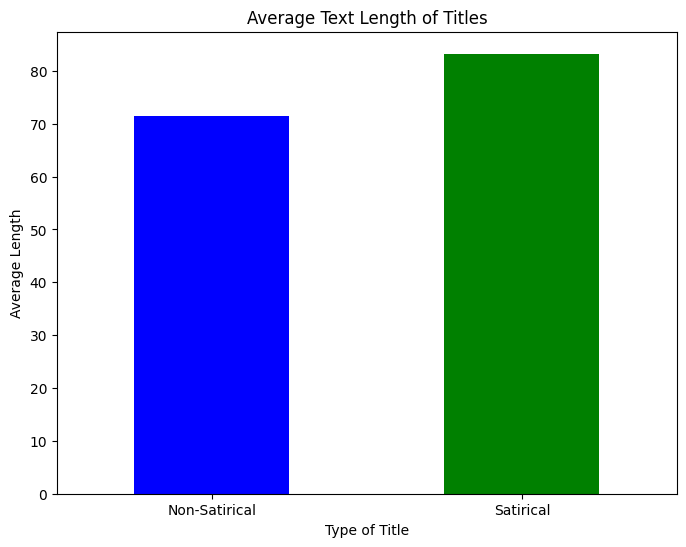

In [4]:
df['text_length'] = df['text'].apply(len)
avg_lengths = df.groupby('label')['text_length'].mean()

plt.figure(figsize=(8, 6))
avg_lengths.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Text Length of Titles')
plt.ylabel('Average Length')
plt.xlabel('Type of Title')
plt.xticks([0, 1], ['Non-Satirical', 'Satirical'], rotation=0)
plt.show()

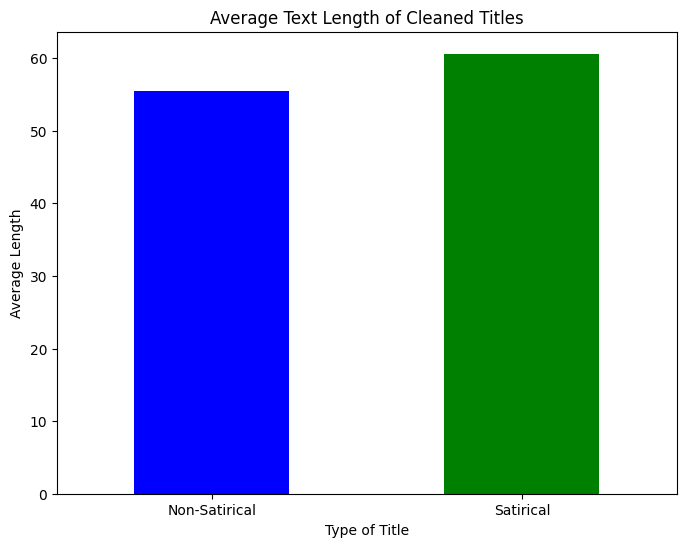

In [5]:
# plot the cleaned text length
df['cleaned_text_length'] = df['cleaned_text'].apply(len)
avg_lengths = df.groupby('label')['cleaned_text_length'].mean()

plt.figure(figsize=(8, 6))
avg_lengths.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Text Length of Cleaned Titles')
plt.ylabel('Average Length')
plt.xlabel('Type of Title')
plt.xticks([0, 1], ['Non-Satirical', 'Satirical'], rotation=0)
plt.show()

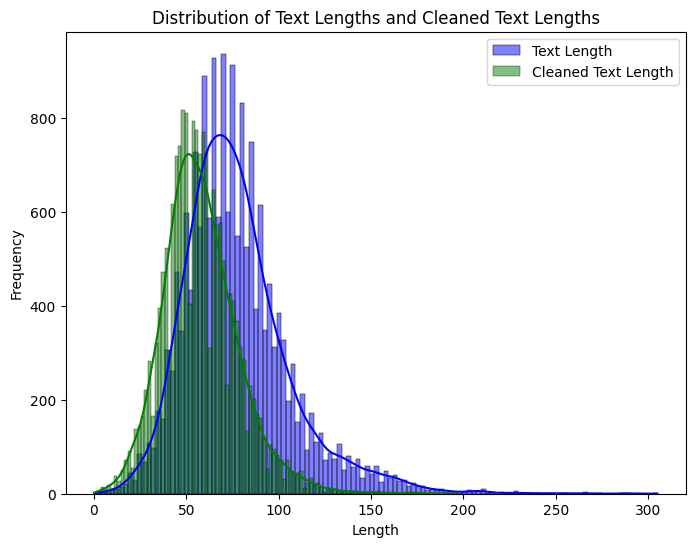

In [6]:
# plot the distribution of text lengths and cleaned text lengths put them on the same plot
plt.figure(figsize=(8, 6))
sns.histplot(df['text_length'], color='blue', kde=True, label='Text Length')
sns.histplot(df['cleaned_text_length'], color='green', kde=True, label='Cleaned Text Length')
plt.title('Distribution of Text Lengths and Cleaned Text Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

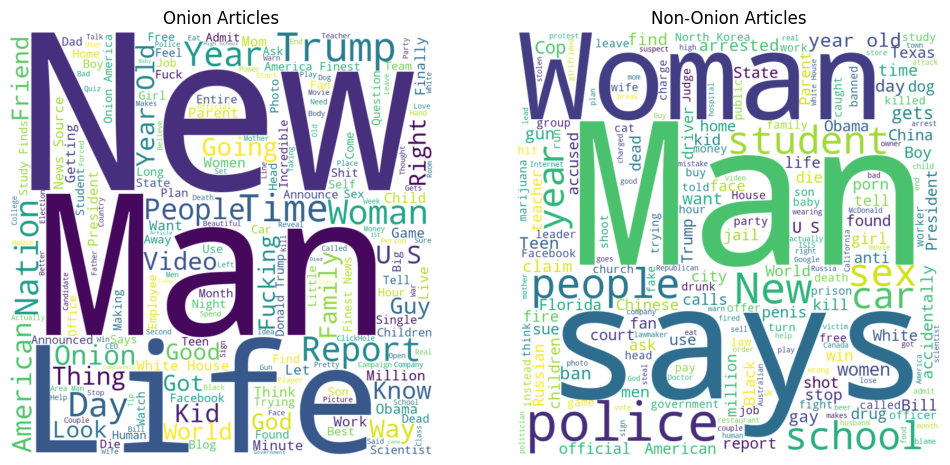

In [7]:
# take only the onion articles and make a word cloud of them, make sure to remove stopwords
onion_articles = df[df['label'] == 1]['text']
onion_articles = ' '.join(onion_articles)
onion_doc = nlp(onion_articles)
onion_words = [token.text for token in onion_doc if not token.is_stop]
onion_words = ' '.join(onion_words)

# take only the non-onion articles and make a word cloud of them, make sure to remove stopwords
non_onion_articles = df[df['label'] == 0]['text']
# take a random sample of 4500 non-onion articles to make the word cloud more readable
non_onion_articles = non_onion_articles.sample(7000)
non_onion_articles = ' '.join(non_onion_articles)
non_onion_doc = nlp(non_onion_articles, disable=['parser', 'ner'])
non_onion_words = [token.text for token in non_onion_doc if not token.is_stop]
non_onion_words = ' '.join(non_onion_words)

# visualize both word clouds in one figure
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(onion_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Onion Articles')
plt.axis('off')
plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(non_onion_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Non-Onion Articles')
plt.axis('off')
plt.show()


# Pronouns Analysis - Morphological and Syntactic Complexity

In [8]:
# Function to count pronouns in a title
def count_pronouns(title):
    doc = nlp(title)
    pronouns = [token.text.lower() for token in doc if token.pos_ == "PRON"]
    return len(pronouns)

# Apply the function to count pronouns in each title
df['pronoun_count'] = df['text'].apply(count_pronouns)

# Display the first few rows of the modified dataframe
df.head()

,text,label,cleaned_text,text_length,cleaned_text_length,pronoun_count
18304,Nike Runner Missed World Record Because His Sh...,0,Nike Runner Missed World Record Shoes Disinteg...,63,51,1
10235,This 60-metre wheelchair ramp could make Brita...,0,60 metre wheelchair ramp Britain great,60,38,0
21035,"'Premature' to talk gun control, White House s...",0,Premature talk gun control White House says Ve...,70,58,0
1366,"Man loses drug money, asks Tucson police for h...",0,Man loses drug money asks Tucson police help N...,201,155,3
9435,Jailed father blames Illuminati for child porn...,0,Jailed father blames Illuminati child porn cau...,91,70,0


In [9]:
# order the df by pronoun_count with the largest values at the top
df.sort_values(by='pronoun_count', ascending=False, inplace=True)

# split it into two dataframes based on the label
on = df[df['label'] == 1]
noto = df[df['label'] == 0]

# compare the pronoun counts
print(on['pronoun_count'].mean(), noto['pronoun_count'].mean())

# compare the 10 highest pronoun counts using the head() method
on.head(10)
noto.head(10)

0.8298888888888889 0.483


,text,label,cleaned_text,text_length,cleaned_text_length,pronoun_count
7312,If you come into my pawn shop with a counterfe...,0,come pawn shop counterfeiting machine tell nee...,266,119,14
16148,Man Cuts Off Own Penis During Fight With Girlf...,0,Man Cuts Penis Fight Girlfriend got drunk got ...,248,121,8
234,"When she says, ""It's not you, it's me,"" it rea...",0,says UCLA study suggests,84,24,7
4330,"Man Arrested After Taking Zebra, Parrot to Bar...",0,Man Arrested Taking Zebra Parrot Bar charged d...,305,170,7
12484,Passengers on an Air France flight were asked ...,0,Passengers Air France flight asked chip pay ca...,285,145,6
14897,Austrian incest rapist Fritzl divorces: report...,0,Austrian incest rapist Fritzl divorces report ...,257,191,5
3228,"'We all make mistakes,' says woman who got bit...",0,mistakes says woman got bit octopus face,80,40,5
9431,He shot his girlfriend in the head but didn't ...,0,shot girlfriend head tell finally went doctor ...,116,58,5
14808,“Woman Who Sucked Off Man On Train Says She Di...,0,Woman Sucked Man Train Says Birthday,79,36,5
19575,"Woman says she was stopped by squirrel, who tu...",0,Woman says stopped squirrel tugged leg led hel...,98,60,5


In [10]:
# Count personal pronouns
def count_personal_pronouns(title):
    doc = nlp(title)
    pronouns = [token.text.lower() for token in doc if token.pos_ == "PRON" and token.tag_ == 'PRP']
    return len(pronouns)

# Apply the function to count personal pronouns in each title in the df
df['pp_count'] = df['text'].apply(count_personal_pronouns)

# let's count the number of words in each df's first 10 titles
def count_words(title):
    doc = nlp(title)
    return len(doc)

# Apply the function to count words in each title of the df
df['word_count'] = df['text'].apply(count_words)

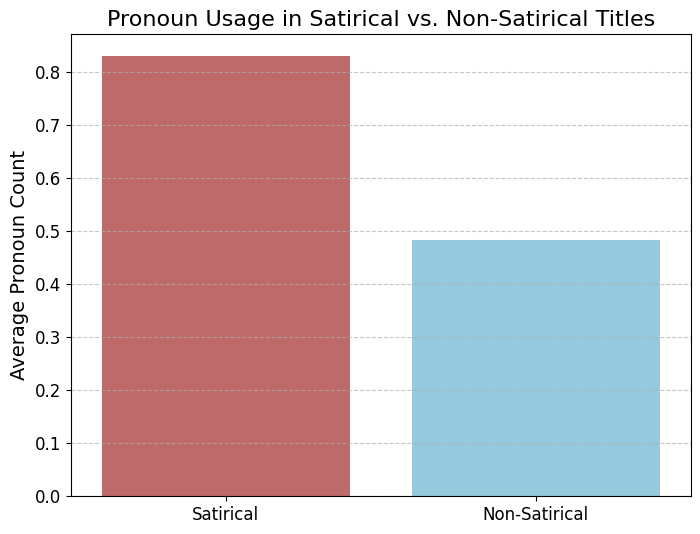

T-Statistic: 23.251960782404428
P-Value: 7.386858679271721e-118


In [11]:
# Statistical Testing: t-test
t_stat_p, p_val_p = ttest_ind(on['pronoun_count'], noto['pronoun_count'])

# Visualization: Create bar graphs to illustrate pronoun usage
plt.figure(figsize=(8, 6))
sns.barplot(x=['Satirical', 'Non-Satirical'], 
            y=[on['pronoun_count'].mean(), noto['pronoun_count'].mean()],
            palette=['indianred', 'skyblue'])
plt.ylabel('Average Pronoun Count', fontsize=14)
plt.title('Pronoun Usage in Satirical vs. Non-Satirical Titles', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print t-test results
print("T-Statistic:", t_stat_p)
print("P-Value:", p_val_p)

/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_43358/1066990037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  on['pp_count'] = df['pp_count'][df['label'] == 1]
/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_43358/1066990037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noto['pp_count'] = df['pp_count'][df['label'] == 0]


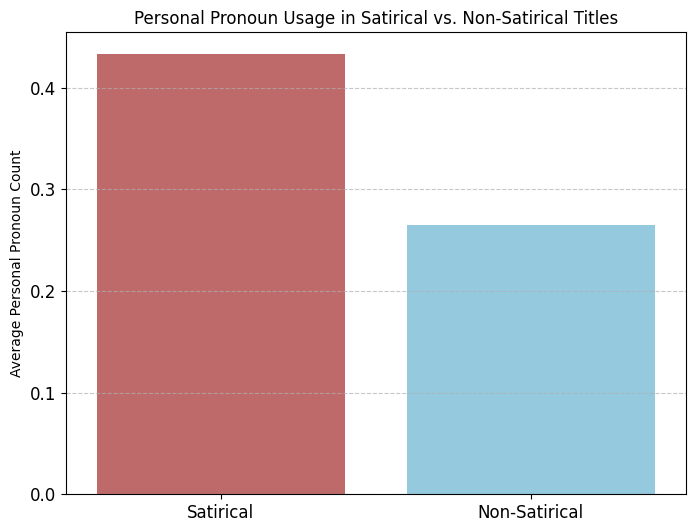

T-Statistic: 16.664588367158927
P-Value: 6.8990493926060445e-62


In [13]:
# add the pp_count to the on and noto dataframes
on['pp_count'] = df['pp_count'][df['label'] == 1]
noto['pp_count'] = df['pp_count'][df['label'] == 0]

# Statistical Testing: Perform t-test
t_stat_pp, p_val_pp = ttest_ind(on['pp_count'], noto['pp_count'])

# Visualization: Create bar graphs to illustrate pronoun usage
plt.figure(figsize=(8, 6))
sns.barplot(x=['Satirical', 'Non-Satirical'], 
            y=[on['pp_count'].mean(), noto['pp_count'].mean()],
            palette=['indianred', 'skyblue'])
plt.ylabel('Average Personal Pronoun Count')
plt.title('Personal Pronoun Usage in Satirical vs. Non-Satirical Titles')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print the t-test results
print("T-Statistic:", t_stat_pp)
print("P-Value:", p_val_pp)

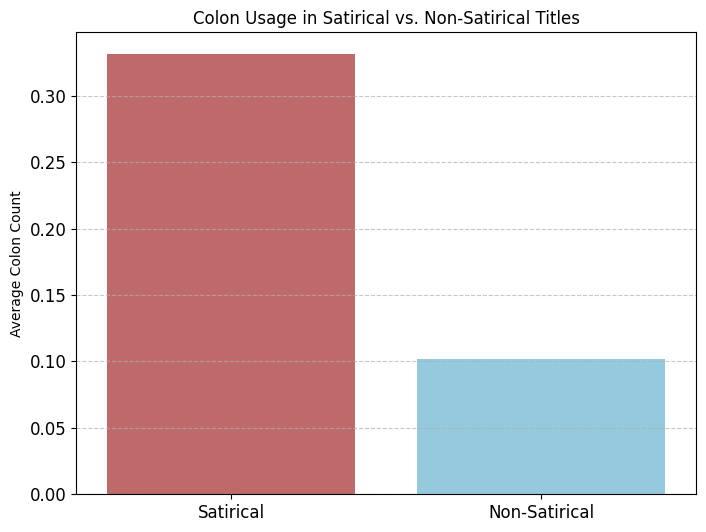

In [14]:
# count the number of : in each title
def count_colons(title):
    return title.count(':')

# Apply the function to count colons in each title in the df
df['colon_count'] = df['text'].apply(count_colons)

on = df[df['label'] == 1]
noto = df[df['label'] == 0]

# visualize the colon counts in each type of title
plt.figure(figsize=(8, 6))
sns.barplot(x=['Satirical', 'Non-Satirical'], 
            y=[on['colon_count'].mean(), noto['colon_count'].mean()],
            palette=['indianred', 'skyblue'])
plt.ylabel('Average Colon Count')
plt.title('Colon Usage in Satirical vs. Non-Satirical Titles')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Semantic Embeddings Analysis

In [15]:
# Function to get document vectors to use as embeddings for the classifier and help with the classification task
def get_doc_vectors(texts):
    docs = [nlp(text) for text in texts]
    # Use the document vector, which averages the word vectors in the document
    vectors = [doc.vector for doc in docs] 
    return vectors

# Generate embeddings
embeddings = get_doc_vectors(df['text'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['label'], test_size=0.2, random_state=42)

# Train a classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# evaluate the model by category seeing if it is better at predicting one category over the other
print(classification_report(y_test, y_pred))


Accuracy: 0.9008333333333334
Precision: 0.8698347107438017
Recall: 0.941307993292342
F1 Score: 0.9041610738255033
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1811
           1       0.87      0.94      0.90      1789

    accuracy                           0.90      3600
   macro avg       0.90      0.90      0.90      3600
weighted avg       0.90      0.90      0.90      3600



## Statistical Analysis

In [17]:
# Let's see some examples of misclassified examples
misclassified = df.loc[y_test[y_test != y_pred].index]
# keep only the text and label columns
misclassified = misclassified[['text', 'label']]

# Let's see some examples of correctly classified examples where label is 1 and print the first 5 correctly classified examples where label is 0
correctly_classified = df.loc[y_test[y_test == y_pred].index]
# keep only the text and label columns
correctly_classified = correctly_classified[['text', 'label']]

# print the first 5 misclassified examples where label is 1 and print the first 5 misclassified examples where label is 0
misclassified[misclassified['label'] == 1].head(5)

,text,label
17123,"Chinese Woman Gives Birth to Septuplets, Has O...",1
19156,Myrtle Beach Resident Refuses To Evacuate From...,1
12516,Ben Affleck: I Was ‘Embarrassed’ By Slave-Owne...,1
1230,Parents’ Most Common Expenditures,1
21194,God Admits He's Way Less Strict With Last Few ...,1


In [18]:
misclassified[misclassified['label'] == 0].head(5)

,text,label
5195,TSA confiscates a toy ray-gun belt buckle. Bec...,0
7282,"After Spending $11,000, Woman Sues Psychic For...",0
14722,Nun Stabs A 7-Year-Old To Teach Him About Jesus,0
14907,Hong Kong Porn Sites Shut Down &amp; Urge User...,0
1404,Rhino Poacher Trampled By An Elephant And Then...,0


In [19]:
correctly_classified[correctly_classified['label'] == 1].head(5)

,text,label
12396,Pope Francis Wears Miter With Faceshield To Co...,1
11374,Study: 25-Foot-Tall Asian Women Remain Underre...,1
5052,Department Of Education Study Finds Teaching T...,1
13919,Video: Diversity Win! These Men Are Wearing Mo...,1
17433,Asian Guy Has Separate Group Of Just Asian Fri...,1


In [20]:
correctly_classified[correctly_classified['label'] == 0].head(5)

,text,label
18094,I caught my teen watching internet porn,0
10789,The man who stole a plane said he didn't need ...,0
22188,Rook at this mess: French park trains crows to...,0
23313,Having a beard and owning a compass seen as 'e...,0
17334,Free Ottawa yoga class scrapped over 'cultural...,0


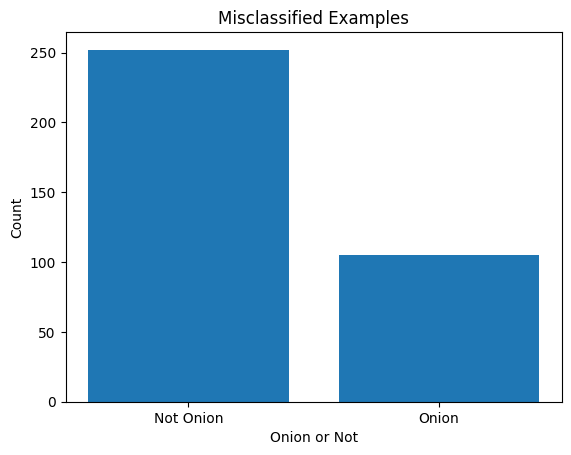

In [21]:
# Let's look at the misclassified examples as a bar chart
plt.bar(['Not Onion', 'Onion'], misclassified['label'].value_counts())
plt.xlabel('Onion or Not')
plt.ylabel('Count')
plt.title('Misclassified Examples')
plt.show()

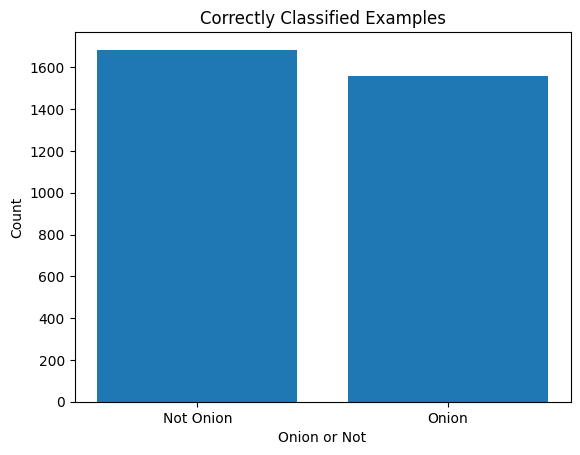

In [22]:
# Let's look at the correctly classified examples as a bar chart
plt.bar(['Not Onion', 'Onion'], correctly_classified['label'].value_counts())
plt.xlabel('Onion or Not')
plt.ylabel('Count')
plt.title('Correctly Classified Examples')
plt.show()

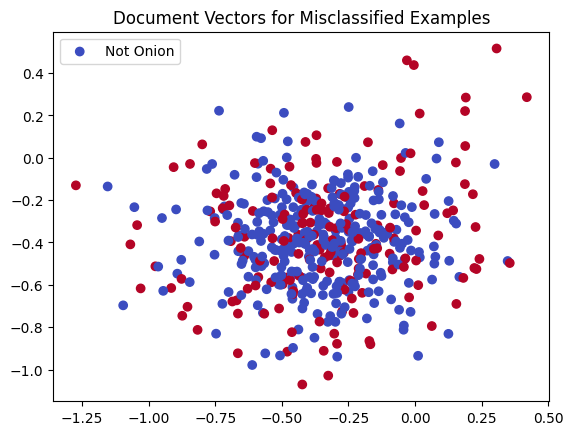

In [11]:
# Let's plot the distribution of the document vectors for the misclassified examples
misclassified_embeddings = np.array(get_doc_vectors(misclassified['text']))
plt.scatter(misclassified_embeddings[:, 0], misclassified_embeddings[:, 1], c=misclassified['label'], cmap='coolwarm')
# legend for the plot red is 0, blue is 1
plt.legend(['Not Onion', 'Onion'])
plt.title('Document Vectors for Misclassified Examples')
plt.show()

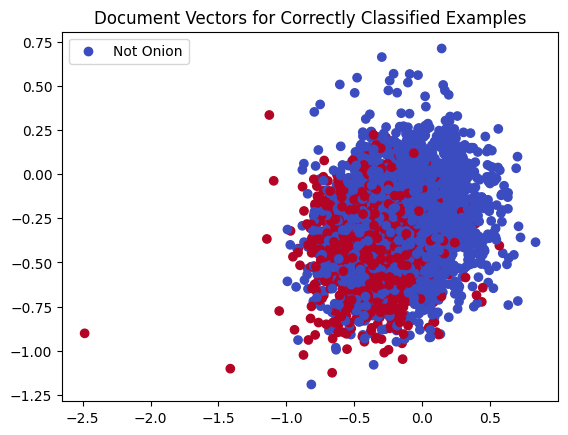

In [18]:
# Let's plot the distribution of the document vectors for the correctly classified examples
correctly_classified_embeddings = np.array(get_doc_vectors(correctly_classified['text']))
plt.scatter(correctly_classified_embeddings[:, 0], correctly_classified_embeddings[:, 1], c=correctly_classified['label'], cmap='coolwarm')
# legend for the plot red is 0, blue is 1
plt.legend(['Not Onion', 'Onion'])
plt.title('Document Vectors for Correctly Classified Examples')
plt.show()

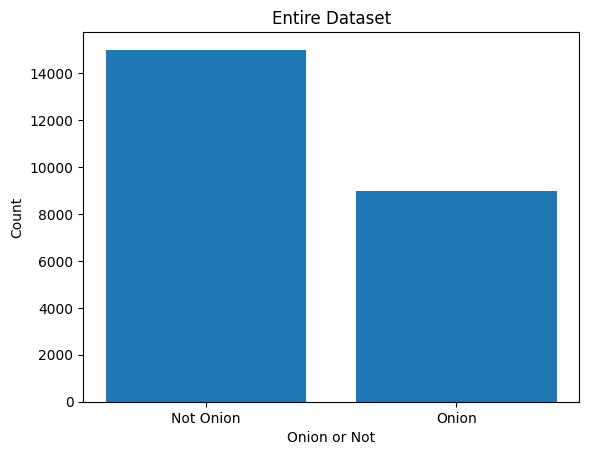

In [14]:
# Let's plot the distribution of the document vectors for the entire dataset
plt.bar(['Not Onion', 'Onion'], df['label'].value_counts())
plt.xlabel('Onion or Not')
plt.ylabel('Count')
plt.title('Entire Dataset')
plt.show()

# tf-idf Analysis

In [3]:
def preprocess_text(text):
    doc = nlp(text)
    # Lemmatize and remove stopwords and punctuation
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Vectorization with TF-IDF
vectorizer = TfidfVectorizer()

# Apply preprocessing and vectorization
df['processed_headline'] = df['text'].apply(preprocess_text)
X = vectorizer.fit_transform(df['processed_headline'])
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Initialize and train the SVM model
svm_model = SVC(kernel='linear', random_state=42)  # Linear kernel is often enough for text data
svm_model.fit(X_train, y_train)

# Predict and evaluate
svm_predictions = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

SVM Accuracy: 0.8359722222222222
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      4577
           1       0.80      0.73      0.76      2623

    accuracy                           0.84      7200
   macro avg       0.83      0.81      0.82      7200
weighted avg       0.83      0.84      0.83      7200



In [12]:
# Initialize and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict and evaluate
nb_predictions = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_predictions))
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))

Naive Bayes Accuracy: 0.7961111111111111
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.97      0.86      4577
           1       0.90      0.50      0.64      2623

    accuracy                           0.80      7200
   macro avg       0.83      0.73      0.75      7200
weighted avg       0.82      0.80      0.78      7200



In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(data):
    return tokenizer(data['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

# Tokenize headlines
tokenized_data = tokenize_data(df)

In [10]:
class HeadlineDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets for training
labels = df['label'].tolist()
dataset = HeadlineDataset(tokenized_data, labels)


In [11]:
from torch.utils.data import random_split

# Split data into 90% train and 10% test
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

[codecarbon INFO @ 09:52:29] Energy consumed for RAM : 0.000775 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:52:29] Energy consumed for all CPUs : 0.005491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:52:29] 0.006266 kWh of electricity used since the beginning.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=50
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()


[codecarbon INFO @ 09:52:52] [setup] RAM Tracking...
[codecarbon INFO @ 09:52:52] [setup] GPU Tracking...
[codecarbon INFO @ 09:52:52] No GPU found.
[codecarbon INFO @ 09:52:52] [setup] CPU Tracking...
[codecarbon WARNING @ 09:52:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 09:52:52] We saw that you have a Apple M2 but we don't know it. Please contact us.
[codecarbon INFO @ 09:52:52] CPU Model on constant consumption mode: Apple M2
[codecarbon INFO @ 09:52:52] >>> Tracker's metadata:
[codecarbon INFO @ 09:52:52]   Platform system: macOS-13.6.3-arm64-arm-64bit
[codecarbon INFO @ 09:52:52]   Python version: 3.11.5
[codecarbon INFO @ 09:52:52]   CodeCarbon version: 2.2.3
[codecarbon INFO @ 09:52:52]   Available RAM : 16.000 GB
[codecarbon INFO @ 09:52:52]   CPU count: 8
[codecarbon INFO @ 09:52:52]   CPU model: Apple M2
[codecarbon INFO @ 09:52:52]   GPU count: None
[codecarbon INFO @ 09:52:52]   GPU model: None


  0%|          | 0/8100 [00:00<?, ?it/s]

/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 09:52:59] Energy consumed for RAM : 0.000825 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:52:59] Energy consumed for all CPUs : 0.005845 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:52:59] 0.006670 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:53:09] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:53:09] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:09] 0.000202 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:53:14] Energy consumed for RAM : 0.000850 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.6349, 'learning_rate': 2.5e-05, 'epoch': 0.02}


[codecarbon INFO @ 09:53:24] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:53:24] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:24] 0.000404 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:53:29] Energy consumed for RAM : 0.000875 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:53:29] Energy consumed for all CPUs : 0.006199 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:29] 0.007075 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:53:39] Energy consumed for RAM : 0.000075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:53:39] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:39] 0.000606 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:53:44] Energy consumed for RAM : 0.000900 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:53:44] Energy consumed for all CPUs : 0.006377 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.5348, 'learning_rate': 5e-05, 'epoch': 0.04}


[codecarbon INFO @ 09:53:54] Energy consumed for RAM : 0.000100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:53:54] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:54] 0.000809 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:53:59] Energy consumed for RAM : 0.000925 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:53:59] Energy consumed for all CPUs : 0.006554 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:59] 0.007479 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:54:09] Energy consumed for RAM : 0.000125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:54:09] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:09] 0.001011 kWh of electricity used since the beginning.


{'loss': 0.4929, 'learning_rate': 4.96875e-05, 'epoch': 0.06}


[codecarbon INFO @ 09:54:14] Energy consumed for RAM : 0.000950 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:54:14] Energy consumed for all CPUs : 0.006731 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:14] 0.007681 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:54:24] Energy consumed for RAM : 0.000150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:54:24] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:24] 0.001213 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:54:29] Energy consumed for RAM : 0.000975 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:54:29] Energy consumed for all CPUs : 0.006908 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:29] 0.007883 kWh of electricity used since the beginning.


{'loss': 0.4468, 'learning_rate': 4.937500000000001e-05, 'epoch': 0.07}


[codecarbon INFO @ 09:54:39] Energy consumed for RAM : 0.000175 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:54:39] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:39] 0.001415 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:54:44] Energy consumed for RAM : 0.001000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:54:44] Energy consumed for all CPUs : 0.007085 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:44] 0.008085 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:54:54] Energy consumed for RAM : 0.000200 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:54:54] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:54] 0.001617 kWh of electricity used since the beginning.


{'loss': 0.4312, 'learning_rate': 4.90625e-05, 'epoch': 0.09}


[codecarbon INFO @ 09:54:59] Energy consumed for RAM : 0.001025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:54:59] Energy consumed for all CPUs : 0.007262 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:59] 0.008287 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:55:09] Energy consumed for RAM : 0.000225 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:55:09] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:09] 0.001819 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:55:14] Energy consumed for RAM : 0.001050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:55:14] Energy consumed for all CPUs : 0.007439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:14] 0.008489 kWh of electricity used since the beginning.


{'loss': 0.3896, 'learning_rate': 4.875e-05, 'epoch': 0.11}


[codecarbon INFO @ 09:55:24] Energy consumed for RAM : 0.000250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:55:24] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:24] 0.002021 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:55:29] Energy consumed for RAM : 0.001075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:55:29] Energy consumed for all CPUs : 0.007616 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:29] 0.008692 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:55:39] Energy consumed for RAM : 0.000275 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:55:39] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:39] 0.002223 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:55:44] Energy consumed for RAM : 0.001100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:55:44] Energy consumed for all CPUs : 0.007794 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.3657, 'learning_rate': 4.8437500000000005e-05, 'epoch': 0.13}


[codecarbon INFO @ 09:55:54] Energy consumed for RAM : 0.000300 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:55:54] Energy consumed for all CPUs : 0.002126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:54] 0.002426 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:55:59] Energy consumed for RAM : 0.001125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:55:59] Energy consumed for all CPUs : 0.007971 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:59] 0.009096 kWh of electricity used since the beginning.


{'loss': 0.3765, 'learning_rate': 4.8125000000000004e-05, 'epoch': 0.15}


[codecarbon INFO @ 09:56:09] Energy consumed for RAM : 0.000325 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:56:09] Energy consumed for all CPUs : 0.002303 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:09] 0.002628 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:56:14] Energy consumed for RAM : 0.001150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:56:14] Energy consumed for all CPUs : 0.008148 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:14] 0.009298 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:56:24] Energy consumed for RAM : 0.000350 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:56:24] Energy consumed for all CPUs : 0.002480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:24] 0.002830 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:56:29] Energy consumed for RAM : 0.001175 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:56:29] Energy consumed for all CPUs : 0.008325 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.3499, 'learning_rate': 4.7812500000000003e-05, 'epoch': 0.17}


[codecarbon INFO @ 09:56:39] Energy consumed for RAM : 0.000375 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:56:39] Energy consumed for all CPUs : 0.002657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:39] 0.003032 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:56:44] Energy consumed for RAM : 0.001200 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:56:44] Energy consumed for all CPUs : 0.008502 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:44] 0.009702 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:56:54] Energy consumed for RAM : 0.000400 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:56:54] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:54] 0.003234 kWh of electricity used since the beginning.


{'loss': 0.3674, 'learning_rate': 4.75e-05, 'epoch': 0.19}


[codecarbon INFO @ 09:56:59] Energy consumed for RAM : 0.001225 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:56:59] Energy consumed for all CPUs : 0.008687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:59] 0.009912 kWh of electricity used since the beginning.
/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 09:57:09] Energy consumed for RAM : 0.000425 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:57:09] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:09] 0.003436 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:57:14] Energy consumed for RAM : 0.001249 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.3604, 'learning_rate': 4.71875e-05, 'epoch': 0.2}


[codecarbon INFO @ 09:57:29] Energy consumed for RAM : 0.001274 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:57:29] Energy consumed for all CPUs : 0.009029 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:29] 0.010303 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:57:39] Energy consumed for RAM : 0.000475 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:57:39] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:39] 0.003840 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:57:44] Energy consumed for RAM : 0.001299 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:57:44] Energy consumed for all CPUs : 0.009207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:44] 0.010505 kWh of electricity used since the beginning.


{'loss': 0.344, 'learning_rate': 4.6875e-05, 'epoch': 0.22}


[codecarbon INFO @ 09:57:54] Energy consumed for RAM : 0.000500 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:57:54] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:54] 0.004043 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:57:59] Energy consumed for RAM : 0.001324 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:57:59] Energy consumed for all CPUs : 0.009384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:59] 0.010707 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:58:09] Energy consumed for RAM : 0.000525 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:58:09] Energy consumed for all CPUs : 0.003720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:09] 0.004245 kWh of electricity used since the beginning.


{'loss': 0.3791, 'learning_rate': 4.65625e-05, 'epoch': 0.24}


[codecarbon INFO @ 09:58:14] Energy consumed for RAM : 0.001349 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:58:14] Energy consumed for all CPUs : 0.009561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:14] 0.010910 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:58:24] Energy consumed for RAM : 0.000550 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:58:24] Energy consumed for all CPUs : 0.003897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:24] 0.004447 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:58:29] Energy consumed for RAM : 0.001374 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:58:29] Energy consumed for all CPUs : 0.009738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:29] 0.011112 kWh of electricity used since the beginning.


{'loss': 0.3817, 'learning_rate': 4.6250000000000006e-05, 'epoch': 0.26}


[codecarbon INFO @ 09:58:39] Energy consumed for RAM : 0.000575 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:58:39] Energy consumed for all CPUs : 0.004074 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:39] 0.004649 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:58:44] Energy consumed for RAM : 0.001399 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:58:44] Energy consumed for all CPUs : 0.009915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:44] 0.011314 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:58:54] Energy consumed for RAM : 0.000600 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:58:54] Energy consumed for all CPUs : 0.004251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:54] 0.004851 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:58:59] Energy consumed for RAM : 0.001424 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:58:59] Energy consumed for all CPUs : 0.010092 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.358, 'learning_rate': 4.59375e-05, 'epoch': 0.28}


[codecarbon INFO @ 09:59:09] Energy consumed for RAM : 0.000625 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:59:09] Energy consumed for all CPUs : 0.004428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:09] 0.005053 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:59:14] Energy consumed for RAM : 0.001449 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:59:14] Energy consumed for all CPUs : 0.010269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:14] 0.011718 kWh of electricity used since the beginning.


{'loss': 0.4044, 'learning_rate': 4.5625e-05, 'epoch': 0.3}


[codecarbon INFO @ 09:59:24] Energy consumed for RAM : 0.000650 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:59:24] Energy consumed for all CPUs : 0.004605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:24] 0.005255 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:59:29] Energy consumed for RAM : 0.001474 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:59:29] Energy consumed for all CPUs : 0.010447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:29] 0.011920 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:59:39] Energy consumed for RAM : 0.000675 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:59:39] Energy consumed for all CPUs : 0.004782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:39] 0.005457 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:59:44] Energy consumed for RAM : 0.001499 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:59:44] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.3797, 'learning_rate': 4.5312500000000004e-05, 'epoch': 0.31}


[codecarbon INFO @ 09:59:54] Energy consumed for RAM : 0.000700 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:59:54] Energy consumed for all CPUs : 0.004959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:54] 0.005660 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:59:59] Energy consumed for RAM : 0.001524 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:59:59] Energy consumed for all CPUs : 0.010801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:59] 0.012324 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:00:09] Energy consumed for RAM : 0.000725 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:00:09] Energy consumed for all CPUs : 0.005137 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:09] 0.005862 kWh of electricity used since the beginning.


{'loss': 0.4777, 'learning_rate': 4.5e-05, 'epoch': 0.33}


[codecarbon INFO @ 10:00:14] Energy consumed for RAM : 0.001549 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:00:14] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:14] 0.012527 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:00:24] Energy consumed for RAM : 0.000750 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:00:24] Energy consumed for all CPUs : 0.005314 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:24] 0.006064 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:00:29] Energy consumed for RAM : 0.001574 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:00:29] Energy consumed for all CPUs : 0.011155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:29] 0.012729 kWh of electricity used since the beginning.


{'loss': 0.3285, 'learning_rate': 4.46875e-05, 'epoch': 0.35}


[codecarbon INFO @ 10:00:39] Energy consumed for RAM : 0.000775 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:00:39] Energy consumed for all CPUs : 0.005491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:39] 0.006266 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:00:44] Energy consumed for RAM : 0.001599 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:00:44] Energy consumed for all CPUs : 0.011332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:44] 0.012931 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:00:54] Energy consumed for RAM : 0.000800 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:00:54] Energy consumed for all CPUs : 0.005668 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:54] 0.006468 kWh of electricity used since the beginning.


{'loss': 0.4581, 'learning_rate': 4.4375e-05, 'epoch': 0.37}


[codecarbon INFO @ 10:01:00] Energy consumed for RAM : 0.001625 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:01:00] Energy consumed for all CPUs : 0.011518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:00] 0.013143 kWh of electricity used since the beginning.
/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:01:09] Energy consumed for RAM : 0.000825 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:01:09] Energy consumed for all CPUs : 0.005845 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:09] 0.006670 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:01:15] Energy consumed for RAM : 0.001649 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.3135, 'learning_rate': 4.40625e-05, 'epoch': 0.39}


[codecarbon INFO @ 10:01:30] Energy consumed for RAM : 0.001674 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:01:30] Energy consumed for all CPUs : 0.011865 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:30] 0.013539 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:01:39] Energy consumed for RAM : 0.000875 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:01:39] Energy consumed for all CPUs : 0.006199 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:39] 0.007074 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:01:45] Energy consumed for RAM : 0.001699 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:01:45] Energy consumed for all CPUs : 0.012042 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:45] 0.013741 kWh of electricity used since the beginning.


{'loss': 0.3281, 'learning_rate': 4.375e-05, 'epoch': 0.41}


[codecarbon INFO @ 10:01:54] Energy consumed for RAM : 0.000900 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:01:54] Energy consumed for all CPUs : 0.006376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:54] 0.007277 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:02:00] Energy consumed for RAM : 0.001724 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:02:00] Energy consumed for all CPUs : 0.012219 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:00] 0.013943 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:02:09] Energy consumed for RAM : 0.000925 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:02:09] Energy consumed for all CPUs : 0.006554 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:09] 0.007479 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:02:15] Energy consumed for RAM : 0.001749 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:02:15] Energy consumed for all CPUs : 0.012397 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.3567, 'learning_rate': 4.3437500000000006e-05, 'epoch': 0.43}


[codecarbon INFO @ 10:02:24] Energy consumed for RAM : 0.000950 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:02:24] Energy consumed for all CPUs : 0.006731 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:24] 0.007681 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:02:30] Energy consumed for RAM : 0.001774 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:02:30] Energy consumed for all CPUs : 0.012574 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:30] 0.014348 kWh of electricity used since the beginning.


{'loss': 0.3885, 'learning_rate': 4.3125000000000005e-05, 'epoch': 0.44}


[codecarbon INFO @ 10:02:39] Energy consumed for RAM : 0.000975 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:02:39] Energy consumed for all CPUs : 0.006908 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:39] 0.007883 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:02:45] Energy consumed for RAM : 0.001799 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:02:45] Energy consumed for all CPUs : 0.012751 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:45] 0.014550 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:02:54] Energy consumed for RAM : 0.001000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:02:54] Energy consumed for all CPUs : 0.007085 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:54] 0.008085 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:03:00] Energy consumed for RAM : 0.001824 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:03:00] Energy consumed for all CPUs : 0.012928 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.285, 'learning_rate': 4.28125e-05, 'epoch': 0.46}


[codecarbon INFO @ 10:03:09] Energy consumed for RAM : 0.001025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:03:09] Energy consumed for all CPUs : 0.007262 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:09] 0.008287 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:03:15] Energy consumed for RAM : 0.001849 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:03:15] Energy consumed for all CPUs : 0.013105 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:15] 0.014954 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:03:24] Energy consumed for RAM : 0.001050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:03:24] Energy consumed for all CPUs : 0.007439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:24] 0.008489 kWh of electricity used since the beginning.


{'loss': 0.3259, 'learning_rate': 4.25e-05, 'epoch': 0.48}


[codecarbon INFO @ 10:03:30] Energy consumed for RAM : 0.001874 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:03:30] Energy consumed for all CPUs : 0.013282 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:30] 0.015156 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:03:39] Energy consumed for RAM : 0.001075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:03:39] Energy consumed for all CPUs : 0.007616 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:39] 0.008691 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:03:45] Energy consumed for RAM : 0.001899 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:03:45] Energy consumed for all CPUs : 0.013459 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:45] 0.015358 kWh of electricity used since the beginning.


{'loss': 0.3816, 'learning_rate': 4.21875e-05, 'epoch': 0.5}


[codecarbon INFO @ 10:03:54] Energy consumed for RAM : 0.001100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:03:54] Energy consumed for all CPUs : 0.007793 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:54] 0.008894 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:04:00] Energy consumed for RAM : 0.001924 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:04:00] Energy consumed for all CPUs : 0.013636 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:00] 0.015560 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:04:09] Energy consumed for RAM : 0.001125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:04:09] Energy consumed for all CPUs : 0.007971 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:09] 0.009096 kWh of electricity used since the beginning.


{'loss': 0.3485, 'learning_rate': 4.1875e-05, 'epoch': 0.52}


[codecarbon INFO @ 10:04:15] Energy consumed for RAM : 0.001949 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:04:15] Energy consumed for all CPUs : 0.013814 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:15] 0.015763 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:04:24] Energy consumed for RAM : 0.001150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:04:24] Energy consumed for all CPUs : 0.008148 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:24] 0.009298 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:04:30] Energy consumed for RAM : 0.001974 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:04:30] Energy consumed for all CPUs : 0.013991 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:30] 0.015965 kWh of electricity used since the beginning.


{'loss': 0.3674, 'learning_rate': 4.156250000000001e-05, 'epoch': 0.54}


[codecarbon INFO @ 10:04:39] Energy consumed for RAM : 0.001175 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:04:39] Energy consumed for all CPUs : 0.008325 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:39] 0.009500 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:04:45] Energy consumed for RAM : 0.001999 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:04:45] Energy consumed for all CPUs : 0.014168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:45] 0.016167 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:04:54] Energy consumed for RAM : 0.001200 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:04:54] Energy consumed for all CPUs : 0.008502 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:54] 0.009702 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:05:00] Energy consumed for RAM : 0.002024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:05:00] Energy consumed for all CPUs : 0.014345 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.3599, 'learning_rate': 4.125e-05, 'epoch': 0.56}


/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:05:09] Energy consumed for RAM : 0.001225 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:05:09] Energy consumed for all CPUs : 0.008679 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:09] 0.009904 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:05:15] Energy consumed for RAM : 0.002049 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:05:15] Energy consumed for all CPUs : 0.014522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:15] 0.016571 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:05:24] Energy consumed for RAM : 0.001250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.2921, 'learning_rate': 4.09375e-05, 'epoch': 0.57}


[codecarbon INFO @ 10:05:30] Energy consumed for RAM : 0.002074 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:05:30] Energy consumed for all CPUs : 0.014699 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:30] 0.016773 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:05:39] Energy consumed for RAM : 0.001275 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:05:39] Energy consumed for all CPUs : 0.009033 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:39] 0.010308 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:05:45] Energy consumed for RAM : 0.002099 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:05:45] Energy consumed for all CPUs : 0.014876 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:45] 0.016975 kWh of electricity used since the beginning.


{'loss': 0.3472, 'learning_rate': 4.0625000000000005e-05, 'epoch': 0.59}


[codecarbon INFO @ 10:05:54] Energy consumed for RAM : 0.001300 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:05:54] Energy consumed for all CPUs : 0.009210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:54] 0.010511 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:06:00] Energy consumed for RAM : 0.002124 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:06:00] Energy consumed for all CPUs : 0.015053 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:00] 0.017177 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:06:09] Energy consumed for RAM : 0.001325 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:06:09] Energy consumed for all CPUs : 0.009387 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:09] 0.010713 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:06:15] Energy consumed for RAM : 0.002149 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:06:15] Energy consumed for all CPUs : 0.015231 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.3879, 'learning_rate': 4.0312500000000004e-05, 'epoch': 0.61}


[codecarbon INFO @ 10:06:24] Energy consumed for RAM : 0.001350 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:06:24] Energy consumed for all CPUs : 0.009565 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:24] 0.010915 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:06:30] Energy consumed for RAM : 0.002174 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:06:30] Energy consumed for all CPUs : 0.015408 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:30] 0.017582 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:06:39] Energy consumed for RAM : 0.001375 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:06:39] Energy consumed for all CPUs : 0.009742 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:39] 0.011117 kWh of electricity used since the beginning.


{'loss': 0.3112, 'learning_rate': 4e-05, 'epoch': 0.63}


[codecarbon INFO @ 10:06:45] Energy consumed for RAM : 0.002199 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:06:45] Energy consumed for all CPUs : 0.015585 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:45] 0.017784 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:06:54] Energy consumed for RAM : 0.001400 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:06:54] Energy consumed for all CPUs : 0.009919 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:54] 0.011319 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:07:00] Energy consumed for RAM : 0.002224 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:07:00] Energy consumed for all CPUs : 0.015762 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:00] 0.017986 kWh of electricity used since the beginning.


{'loss': 0.3113, 'learning_rate': 3.96875e-05, 'epoch': 0.65}


[codecarbon INFO @ 10:07:09] Energy consumed for RAM : 0.001425 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:07:09] Energy consumed for all CPUs : 0.010096 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:09] 0.011521 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:07:15] Energy consumed for RAM : 0.002249 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:07:15] Energy consumed for all CPUs : 0.015939 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:15] 0.018188 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:07:24] Energy consumed for RAM : 0.001450 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:07:24] Energy consumed for all CPUs : 0.010273 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:24] 0.011723 kWh of electricity used since the beginning.


{'loss': 0.3217, 'learning_rate': 3.9375e-05, 'epoch': 0.67}


[codecarbon INFO @ 10:07:30] Energy consumed for RAM : 0.002274 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:07:30] Energy consumed for all CPUs : 0.016116 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:30] 0.018390 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:07:39] Energy consumed for RAM : 0.001475 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:07:39] Energy consumed for all CPUs : 0.010450 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:39] 0.011925 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:07:45] Energy consumed for RAM : 0.002299 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:07:45] Energy consumed for all CPUs : 0.016293 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:45] 0.018592 kWh of electricity used since the beginning.


{'loss': 0.3361, 'learning_rate': 3.90625e-05, 'epoch': 0.69}


[codecarbon INFO @ 10:07:54] Energy consumed for RAM : 0.001500 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:07:54] Energy consumed for all CPUs : 0.010627 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:54] 0.012128 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:08:00] Energy consumed for RAM : 0.002324 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:08:00] Energy consumed for all CPUs : 0.016470 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:00] 0.018794 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:08:09] Energy consumed for RAM : 0.001525 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:08:09] Energy consumed for all CPUs : 0.010804 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:09] 0.012330 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:08:15] Energy consumed for RAM : 0.002349 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:08:15] Energy consumed for all CPUs : 0.016647 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.269, 'learning_rate': 3.875e-05, 'epoch': 0.7}


[codecarbon INFO @ 10:08:24] Energy consumed for RAM : 0.001550 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:08:24] Energy consumed for all CPUs : 0.010982 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:24] 0.012532 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:08:30] Energy consumed for RAM : 0.002374 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:08:30] Energy consumed for all CPUs : 0.016825 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:30] 0.019199 kWh of electricity used since the beginning.


{'loss': 0.3036, 'learning_rate': 3.8437500000000006e-05, 'epoch': 0.72}


[codecarbon INFO @ 10:08:39] Energy consumed for RAM : 0.001575 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:08:39] Energy consumed for all CPUs : 0.011159 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:39] 0.012734 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:08:45] Energy consumed for RAM : 0.002399 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:08:45] Energy consumed for all CPUs : 0.017002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:45] 0.019401 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:08:54] Energy consumed for RAM : 0.001600 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:08:54] Energy consumed for all CPUs : 0.011336 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:54] 0.012936 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:09:00] Energy consumed for RAM : 0.002424 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:09:00] Energy consumed for all CPUs : 0.017179 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.3315, 'learning_rate': 3.8125e-05, 'epoch': 0.74}


/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:09:09] Energy consumed for RAM : 0.001625 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:09:09] Energy consumed for all CPUs : 0.011513 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:09] 0.013138 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:09:15] Energy consumed for RAM : 0.002449 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:09:15] Energy consumed for all CPUs : 0.017356 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:15] 0.019805 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:09:24] Energy consumed for RAM : 0.001650 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.3265, 'learning_rate': 3.78125e-05, 'epoch': 0.76}


[codecarbon INFO @ 10:09:39] Energy consumed for RAM : 0.001675 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:09:39] Energy consumed for all CPUs : 0.011867 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:39] 0.013542 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:09:45] Energy consumed for RAM : 0.002499 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:09:45] Energy consumed for all CPUs : 0.017710 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:45] 0.020209 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:09:54] Energy consumed for RAM : 0.001700 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:09:54] Energy consumed for all CPUs : 0.012044 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:54] 0.013744 kWh of electricity used since the beginning.


{'loss': 0.2953, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.78}


[codecarbon INFO @ 10:10:00] Energy consumed for RAM : 0.002524 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:10:00] Energy consumed for all CPUs : 0.017887 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:00] 0.020411 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:10:09] Energy consumed for RAM : 0.001725 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:10:09] Energy consumed for all CPUs : 0.012221 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:09] 0.013947 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:10:15] Energy consumed for RAM : 0.002549 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:10:15] Energy consumed for all CPUs : 0.018064 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:15] 0.020614 kWh of electricity used since the beginning.


{'loss': 0.3107, 'learning_rate': 3.71875e-05, 'epoch': 0.8}


[codecarbon INFO @ 10:10:24] Energy consumed for RAM : 0.001750 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:10:24] Energy consumed for all CPUs : 0.012398 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:24] 0.014149 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:10:30] Energy consumed for RAM : 0.002574 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:10:30] Energy consumed for all CPUs : 0.018242 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:30] 0.020816 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:10:39] Energy consumed for RAM : 0.001775 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:10:39] Energy consumed for all CPUs : 0.012576 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:39] 0.014351 kWh of electricity used since the beginning.


{'loss': 0.3083, 'learning_rate': 3.6875e-05, 'epoch': 0.81}


[codecarbon INFO @ 10:10:45] Energy consumed for RAM : 0.002599 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:10:45] Energy consumed for all CPUs : 0.018419 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:45] 0.021018 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:10:54] Energy consumed for RAM : 0.001800 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:10:54] Energy consumed for all CPUs : 0.012753 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:54] 0.014553 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:00] Energy consumed for RAM : 0.002624 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:11:00] Energy consumed for all CPUs : 0.018596 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:00] 0.021220 kWh of electricity used since the beginning.


{'loss': 0.3283, 'learning_rate': 3.65625e-05, 'epoch': 0.83}


[codecarbon INFO @ 10:11:09] Energy consumed for RAM : 0.001825 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:11:09] Energy consumed for all CPUs : 0.012930 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:09] 0.014755 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:15] Energy consumed for RAM : 0.002649 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:11:15] Energy consumed for all CPUs : 0.018773 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:15] 0.021422 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:24] Energy consumed for RAM : 0.001850 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:11:24] Energy consumed for all CPUs : 0.013107 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:24] 0.014957 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:30] Energy consumed for RAM : 0.002674 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:11:30] Energy consumed for all CPUs : 0.018950 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.2654, 'learning_rate': 3.625e-05, 'epoch': 0.85}


[codecarbon INFO @ 10:11:39] Energy consumed for RAM : 0.001875 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:11:39] Energy consumed for all CPUs : 0.013284 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:39] 0.015159 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:45] Energy consumed for RAM : 0.002699 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:11:45] Energy consumed for all CPUs : 0.019127 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:45] 0.021826 kWh of electricity used since the beginning.


{'loss': 0.3908, 'learning_rate': 3.59375e-05, 'epoch': 0.87}


[codecarbon INFO @ 10:11:54] Energy consumed for RAM : 0.001900 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:11:54] Energy consumed for all CPUs : 0.013461 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:54] 0.015362 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:12:00] Energy consumed for RAM : 0.002724 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:12:00] Energy consumed for all CPUs : 0.019304 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:00] 0.022028 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:12:09] Energy consumed for RAM : 0.001925 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:12:09] Energy consumed for all CPUs : 0.013638 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:09] 0.015564 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:12:15] Energy consumed for RAM : 0.002749 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:12:15] Energy consumed for all CPUs : 0.019481 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.325, 'learning_rate': 3.5625000000000005e-05, 'epoch': 0.89}


[codecarbon INFO @ 10:12:24] Energy consumed for RAM : 0.001950 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:12:24] Energy consumed for all CPUs : 0.013815 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:24] 0.015766 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:12:30] Energy consumed for RAM : 0.002774 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:12:30] Energy consumed for all CPUs : 0.019658 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:30] 0.022433 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:12:39] Energy consumed for RAM : 0.001975 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:12:39] Energy consumed for all CPUs : 0.013993 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:39] 0.015968 kWh of electricity used since the beginning.


{'loss': 0.3476, 'learning_rate': 3.5312500000000005e-05, 'epoch': 0.91}


[codecarbon INFO @ 10:12:45] Energy consumed for RAM : 0.002799 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:12:45] Energy consumed for all CPUs : 0.019836 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:45] 0.022635 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:12:54] Energy consumed for RAM : 0.002000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:12:54] Energy consumed for all CPUs : 0.014170 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:54] 0.016170 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:13:00] Energy consumed for RAM : 0.002824 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:13:00] Energy consumed for all CPUs : 0.020013 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:00] 0.022837 kWh of electricity used since the beginning.


{'loss': 0.2737, 'learning_rate': 3.5e-05, 'epoch': 0.93}


[codecarbon INFO @ 10:13:10] Energy consumed for RAM : 0.002025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:13:10] Energy consumed for all CPUs : 0.014349 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:10] 0.016375 kWh of electricity used since the beginning.
/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:13:15] Energy consumed for RAM : 0.002849 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:13:15] Energy consumed for all CPUs : 0.020190 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:15] 0.023039 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:13:24] Energy consumed for RAM : 0.002049 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.3524, 'learning_rate': 3.46875e-05, 'epoch': 0.94}


[codecarbon INFO @ 10:13:40] Energy consumed for RAM : 0.002074 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:13:40] Energy consumed for all CPUs : 0.014692 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:40] 0.016766 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:13:45] Energy consumed for RAM : 0.002899 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:13:45] Energy consumed for all CPUs : 0.020544 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:45] 0.023443 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:13:55] Energy consumed for RAM : 0.002099 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:13:55] Energy consumed for all CPUs : 0.014869 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:55] 0.016968 kWh of electricity used since the beginning.


{'loss': 0.3165, 'learning_rate': 3.4375e-05, 'epoch': 0.96}


[codecarbon INFO @ 10:14:00] Energy consumed for RAM : 0.002924 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:14:00] Energy consumed for all CPUs : 0.020721 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:00] 0.023645 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:14:10] Energy consumed for RAM : 0.002124 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:14:10] Energy consumed for all CPUs : 0.015046 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:10] 0.017170 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:14:15] Energy consumed for RAM : 0.002949 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:14:15] Energy consumed for all CPUs : 0.020898 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:15] 0.023847 kWh of electricity used since the beginning.


{'loss': 0.3378, 'learning_rate': 3.40625e-05, 'epoch': 0.98}


[codecarbon INFO @ 10:14:25] Energy consumed for RAM : 0.002149 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:14:25] Energy consumed for all CPUs : 0.015223 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:25] 0.017372 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:14:30] Energy consumed for RAM : 0.002974 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:14:30] Energy consumed for all CPUs : 0.021075 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:30] 0.024050 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:14:40] Energy consumed for RAM : 0.002174 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:14:40] Energy consumed for all CPUs : 0.015400 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:40] 0.017574 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:14:45] Energy consumed for RAM : 0.002999 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:14:45] Energy consumed for all CPUs : 0.021253 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1971, 'learning_rate': 3.375000000000001e-05, 'epoch': 1.0}


  0%|          | 0/150 [00:00<?, ?it/s]

[codecarbon INFO @ 10:14:55] Energy consumed for RAM : 0.002199 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:14:55] Energy consumed for all CPUs : 0.015578 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:55] 0.017776 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:15:00] Energy consumed for RAM : 0.003024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:15:00] Energy consumed for all CPUs : 0.021430 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:00] 0.024454 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:15:10] Energy consumed for RAM : 0.002224 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:15:10] Energy consumed for all CPUs : 0.015755 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:10] 0.017979 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:15:15] Energy consumed for RAM : 0.003049 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:15:15] Energy consumed for all CPUs : 0.021607 kWh. Total CPU Power : 42.5 W
[codeca

{'eval_loss': 0.3168407678604126, 'eval_runtime': 31.8514, 'eval_samples_per_second': 75.35, 'eval_steps_per_second': 4.709, 'epoch': 1.0}


[codecarbon INFO @ 10:15:25] Energy consumed for RAM : 0.002249 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:15:25] Energy consumed for all CPUs : 0.015932 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:25] 0.018181 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:15:30] Energy consumed for RAM : 0.003074 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:15:30] Energy consumed for all CPUs : 0.021784 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:30] 0.024858 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:15:40] Energy consumed for RAM : 0.002274 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:15:40] Energy consumed for all CPUs : 0.016109 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:40] 0.018383 kWh of electricity used since the beginning.


{'loss': 0.1968, 'learning_rate': 3.34375e-05, 'epoch': 1.02}


[codecarbon INFO @ 10:15:45] Energy consumed for RAM : 0.003099 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:15:45] Energy consumed for all CPUs : 0.021961 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:45] 0.025060 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:15:55] Energy consumed for RAM : 0.002299 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:15:55] Energy consumed for all CPUs : 0.016286 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:55] 0.018585 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:16:00] Energy consumed for RAM : 0.003124 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:16:00] Energy consumed for all CPUs : 0.022138 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:00] 0.025262 kWh of electricity used since the beginning.


{'loss': 0.1617, 'learning_rate': 3.3125e-05, 'epoch': 1.04}


[codecarbon INFO @ 10:16:10] Energy consumed for RAM : 0.002324 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:16:10] Energy consumed for all CPUs : 0.016463 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:10] 0.018787 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:16:15] Energy consumed for RAM : 0.003149 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:16:15] Energy consumed for all CPUs : 0.022315 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:15] 0.025464 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:16:25] Energy consumed for RAM : 0.002349 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:16:25] Energy consumed for all CPUs : 0.016640 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:25] 0.018989 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:16:30] Energy consumed for RAM : 0.003174 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:16:30] Energy consumed for all CPUs : 0.022492 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.2108, 'learning_rate': 3.2812500000000005e-05, 'epoch': 1.06}


[codecarbon INFO @ 10:16:40] Energy consumed for RAM : 0.002374 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:16:40] Energy consumed for all CPUs : 0.016817 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:40] 0.019191 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:16:45] Energy consumed for RAM : 0.003199 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:16:45] Energy consumed for all CPUs : 0.022670 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:45] 0.025869 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:16:55] Energy consumed for RAM : 0.002399 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:16:55] Energy consumed for all CPUs : 0.016995 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:55] 0.019393 kWh of electricity used since the beginning.


{'loss': 0.1697, 'learning_rate': 3.2500000000000004e-05, 'epoch': 1.07}


[codecarbon INFO @ 10:17:00] Energy consumed for RAM : 0.003224 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:17:00] Energy consumed for all CPUs : 0.022847 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:00] 0.026071 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:17:10] Energy consumed for RAM : 0.002424 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:17:10] Energy consumed for all CPUs : 0.017172 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:10] 0.019596 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:17:15] Energy consumed for RAM : 0.003249 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:17:15] Energy consumed for all CPUs : 0.023024 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:15] 0.026273 kWh of electricity used since the beginning.


{'loss': 0.1594, 'learning_rate': 3.21875e-05, 'epoch': 1.09}


[codecarbon INFO @ 10:17:25] Energy consumed for RAM : 0.002449 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:17:25] Energy consumed for all CPUs : 0.017349 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:25] 0.019798 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:17:30] Energy consumed for RAM : 0.003274 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:17:30] Energy consumed for all CPUs : 0.023201 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:30] 0.026475 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:17:40] Energy consumed for RAM : 0.002474 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:17:40] Energy consumed for all CPUs : 0.017526 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:40] 0.020000 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:17:45] Energy consumed for RAM : 0.003299 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:17:45] Energy consumed for all CPUs : 0.023378 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1263, 'learning_rate': 3.1875e-05, 'epoch': 1.11}


[codecarbon INFO @ 10:17:55] Energy consumed for RAM : 0.002499 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:17:55] Energy consumed for all CPUs : 0.017708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:55] 0.020207 kWh of electricity used since the beginning.
/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:18:00] Energy consumed for RAM : 0.003324 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:18:00] Energy consumed for all CPUs : 0.023555 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:00] 0.026879 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:18:10] Energy consumed for RAM : 0.002523 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.1431, 'learning_rate': 3.15625e-05, 'epoch': 1.13}


[codecarbon INFO @ 10:18:25] Energy consumed for RAM : 0.002548 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:18:25] Energy consumed for all CPUs : 0.018058 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:25] 0.020606 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:18:30] Energy consumed for RAM : 0.003374 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:18:30] Energy consumed for all CPUs : 0.023909 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:30] 0.027283 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:18:40] Energy consumed for RAM : 0.002573 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:18:40] Energy consumed for all CPUs : 0.018235 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:40] 0.020808 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:18:45] Energy consumed for RAM : 0.003399 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:18:45] Energy consumed for all CPUs : 0.024086 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1709, 'learning_rate': 3.125e-05, 'epoch': 1.15}


[codecarbon INFO @ 10:18:55] Energy consumed for RAM : 0.002598 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:18:55] Energy consumed for all CPUs : 0.018412 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:55] 0.021010 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:19:00] Energy consumed for RAM : 0.003424 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:19:00] Energy consumed for all CPUs : 0.024264 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:00] 0.027688 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:19:10] Energy consumed for RAM : 0.002623 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:19:10] Energy consumed for all CPUs : 0.018589 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:10] 0.021212 kWh of electricity used since the beginning.


{'loss': 0.1846, 'learning_rate': 3.09375e-05, 'epoch': 1.17}


[codecarbon INFO @ 10:19:15] Energy consumed for RAM : 0.003449 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:19:15] Energy consumed for all CPUs : 0.024441 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:15] 0.027890 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:19:25] Energy consumed for RAM : 0.002648 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:19:25] Energy consumed for all CPUs : 0.018766 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:25] 0.021414 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:19:30] Energy consumed for RAM : 0.003474 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:19:30] Energy consumed for all CPUs : 0.024618 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:30] 0.028092 kWh of electricity used since the beginning.


{'loss': 0.1423, 'learning_rate': 3.0625000000000006e-05, 'epoch': 1.19}


[codecarbon INFO @ 10:19:40] Energy consumed for RAM : 0.002673 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:19:40] Energy consumed for all CPUs : 0.018943 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:40] 0.021617 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:19:45] Energy consumed for RAM : 0.003499 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:19:45] Energy consumed for all CPUs : 0.024795 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:45] 0.028294 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:19:55] Energy consumed for RAM : 0.002698 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:19:55] Energy consumed for all CPUs : 0.019120 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:55] 0.021819 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:20:00] Energy consumed for RAM : 0.003524 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:20:00] Energy consumed for all CPUs : 0.024972 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1569, 'learning_rate': 3.0312499999999998e-05, 'epoch': 1.2}


[codecarbon INFO @ 10:20:10] Energy consumed for RAM : 0.002723 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:20:10] Energy consumed for all CPUs : 0.019297 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:10] 0.022021 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:20:15] Energy consumed for RAM : 0.003549 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:20:15] Energy consumed for all CPUs : 0.025149 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:15] 0.028698 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:20:25] Energy consumed for RAM : 0.002748 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:20:25] Energy consumed for all CPUs : 0.019474 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:25] 0.022223 kWh of electricity used since the beginning.


{'loss': 0.2141, 'learning_rate': 3e-05, 'epoch': 1.22}


[codecarbon INFO @ 10:20:30] Energy consumed for RAM : 0.003574 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:20:30] Energy consumed for all CPUs : 0.025326 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:30] 0.028900 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:20:40] Energy consumed for RAM : 0.002773 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:20:40] Energy consumed for all CPUs : 0.019652 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:40] 0.022425 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:20:45] Energy consumed for RAM : 0.003599 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:20:45] Energy consumed for all CPUs : 0.025503 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:45] 0.029103 kWh of electricity used since the beginning.


{'loss': 0.216, 'learning_rate': 2.96875e-05, 'epoch': 1.24}


[codecarbon INFO @ 10:20:55] Energy consumed for RAM : 0.002798 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:20:55] Energy consumed for all CPUs : 0.019829 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:55] 0.022627 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:21:00] Energy consumed for RAM : 0.003624 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:21:00] Energy consumed for all CPUs : 0.025681 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:00] 0.029305 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:21:10] Energy consumed for RAM : 0.002823 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:21:10] Energy consumed for all CPUs : 0.020006 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:10] 0.022829 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:21:15] Energy consumed for RAM : 0.003649 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:21:15] Energy consumed for all CPUs : 0.025858 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1747, 'learning_rate': 2.9375000000000003e-05, 'epoch': 1.26}


[codecarbon INFO @ 10:21:25] Energy consumed for RAM : 0.002848 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:21:25] Energy consumed for all CPUs : 0.020183 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:25] 0.023031 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:21:30] Energy consumed for RAM : 0.003674 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:21:30] Energy consumed for all CPUs : 0.026035 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:30] 0.029709 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:21:40] Energy consumed for RAM : 0.002873 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:21:40] Energy consumed for all CPUs : 0.020360 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:40] 0.023233 kWh of electricity used since the beginning.


{'loss': 0.1689, 'learning_rate': 2.9062500000000005e-05, 'epoch': 1.28}


[codecarbon INFO @ 10:21:45] Energy consumed for RAM : 0.003699 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:21:45] Energy consumed for all CPUs : 0.026212 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:45] 0.029911 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:21:55] Energy consumed for RAM : 0.002898 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:21:55] Energy consumed for all CPUs : 0.020537 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:55] 0.023436 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:22:00] Energy consumed for RAM : 0.003724 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:22:00] Energy consumed for all CPUs : 0.026389 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:00] 0.030113 kWh of electricity used since the beginning.


{'loss': 0.2062, 'learning_rate': 2.8749999999999997e-05, 'epoch': 1.3}


[codecarbon INFO @ 10:22:10] Energy consumed for RAM : 0.002924 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:22:10] Energy consumed for all CPUs : 0.020717 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:10] 0.023641 kWh of electricity used since the beginning.
/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:22:15] Energy consumed for RAM : 0.003749 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:22:15] Energy consumed for all CPUs : 0.026566 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:15] 0.030315 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:22:25] Energy consumed for RAM : 0.002948 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.1927, 'learning_rate': 2.84375e-05, 'epoch': 1.31}


[codecarbon INFO @ 10:22:40] Energy consumed for RAM : 0.002973 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:22:40] Energy consumed for all CPUs : 0.021067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:40] 0.024039 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:22:45] Energy consumed for RAM : 0.003799 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:22:45] Energy consumed for all CPUs : 0.026920 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:45] 0.030720 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:22:55] Energy consumed for RAM : 0.002998 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:22:55] Energy consumed for all CPUs : 0.021244 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:55] 0.024242 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:23:00] Energy consumed for RAM : 0.003824 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:23:00] Energy consumed for all CPUs : 0.027097 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1822, 'learning_rate': 2.8125000000000003e-05, 'epoch': 1.33}


[codecarbon INFO @ 10:23:10] Energy consumed for RAM : 0.003023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:23:10] Energy consumed for all CPUs : 0.021421 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:10] 0.024444 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:23:15] Energy consumed for RAM : 0.003849 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:23:15] Energy consumed for all CPUs : 0.027275 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:15] 0.031124 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:23:25] Energy consumed for RAM : 0.003048 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:23:25] Energy consumed for all CPUs : 0.021598 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:25] 0.024646 kWh of electricity used since the beginning.


{'loss': 0.1969, 'learning_rate': 2.7812500000000002e-05, 'epoch': 1.35}


[codecarbon INFO @ 10:23:30] Energy consumed for RAM : 0.003874 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:23:30] Energy consumed for all CPUs : 0.027452 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:30] 0.031326 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:23:40] Energy consumed for RAM : 0.003073 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:23:40] Energy consumed for all CPUs : 0.021775 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:40] 0.024848 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:23:45] Energy consumed for RAM : 0.003899 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:23:45] Energy consumed for all CPUs : 0.027629 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:45] 0.031528 kWh of electricity used since the beginning.


{'loss': 0.2017, 'learning_rate': 2.7500000000000004e-05, 'epoch': 1.37}


[codecarbon INFO @ 10:23:55] Energy consumed for RAM : 0.003098 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:23:55] Energy consumed for all CPUs : 0.021952 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:55] 0.025050 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:24:00] Energy consumed for RAM : 0.003924 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:00] Energy consumed for all CPUs : 0.027806 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:00] 0.031730 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:24:10] Energy consumed for RAM : 0.003123 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:10] Energy consumed for all CPUs : 0.022129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:10] 0.025252 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:24:15] Energy consumed for RAM : 0.003949 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:15] Energy consumed for all CPUs : 0.027983 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1256, 'learning_rate': 2.71875e-05, 'epoch': 1.39}


[codecarbon INFO @ 10:24:25] Energy consumed for RAM : 0.003148 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:25] Energy consumed for all CPUs : 0.022306 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:25] 0.025454 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:24:30] Energy consumed for RAM : 0.003974 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:30] Energy consumed for all CPUs : 0.028160 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:30] 0.032134 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:24:40] Energy consumed for RAM : 0.003173 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:40] Energy consumed for all CPUs : 0.022483 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:40] 0.025656 kWh of electricity used since the beginning.


{'loss': 0.212, 'learning_rate': 2.6875e-05, 'epoch': 1.41}


[codecarbon INFO @ 10:24:45] Energy consumed for RAM : 0.003999 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:45] Energy consumed for all CPUs : 0.028337 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:45] 0.032337 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:24:55] Energy consumed for RAM : 0.003198 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:55] Energy consumed for all CPUs : 0.022661 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:55] 0.025859 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:25:00] Energy consumed for RAM : 0.004024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:25:00] Energy consumed for all CPUs : 0.028514 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:00] 0.032539 kWh of electricity used since the beginning.


{'loss': 0.1977, 'learning_rate': 2.6562500000000002e-05, 'epoch': 1.43}


[codecarbon INFO @ 10:25:10] Energy consumed for RAM : 0.003223 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:25:10] Energy consumed for all CPUs : 0.022838 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:10] 0.026061 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:25:15] Energy consumed for RAM : 0.004049 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:25:15] Energy consumed for all CPUs : 0.028692 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:15] 0.032741 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:25:25] Energy consumed for RAM : 0.003248 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:25:25] Energy consumed for all CPUs : 0.023015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:25] 0.026263 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:25:30] Energy consumed for RAM : 0.004074 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:25:30] Energy consumed for all CPUs : 0.028869 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.2011, 'learning_rate': 2.625e-05, 'epoch': 1.44}


[codecarbon INFO @ 10:25:40] Energy consumed for RAM : 0.003273 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:25:40] Energy consumed for all CPUs : 0.023192 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:40] 0.026465 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:25:45] Energy consumed for RAM : 0.004099 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:25:45] Energy consumed for all CPUs : 0.029046 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:45] 0.033145 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:25:55] Energy consumed for RAM : 0.003298 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:25:55] Energy consumed for all CPUs : 0.023369 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:55] 0.026667 kWh of electricity used since the beginning.


{'loss': 0.191, 'learning_rate': 2.5937500000000004e-05, 'epoch': 1.46}


[codecarbon INFO @ 10:26:00] Energy consumed for RAM : 0.004124 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:26:00] Energy consumed for all CPUs : 0.029223 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:26:00] 0.033347 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:26:10] Energy consumed for RAM : 0.003323 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:26:10] Energy consumed for all CPUs : 0.023546 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:26:10] 0.026869 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:26:15] Energy consumed for RAM : 0.004149 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:26:15] Energy consumed for all CPUs : 0.029400 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:26:15] 0.033549 kWh of electricity used since the beginning.


{'loss': 0.1638, 'learning_rate': 2.5625e-05, 'epoch': 1.48}


/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:26:25] Energy consumed for RAM : 0.003348 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:26:25] Energy consumed for all CPUs : 0.023723 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:26:25] 0.027071 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:26:30] Energy consumed for RAM : 0.004174 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:26:30] Energy consumed for all CPUs : 0.029577 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:26:30] 0.033752 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:26:40] Energy consumed for RAM : 0.003373 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.1575, 'learning_rate': 2.53125e-05, 'epoch': 1.5}


[codecarbon INFO @ 10:26:55] Energy consumed for RAM : 0.003398 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:26:55] Energy consumed for all CPUs : 0.024077 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:26:55] 0.027476 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:27:00] Energy consumed for RAM : 0.004224 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:27:00] Energy consumed for all CPUs : 0.029932 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:00] 0.034156 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:27:10] Energy consumed for RAM : 0.003423 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:27:10] Energy consumed for all CPUs : 0.024255 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:10] 0.027678 kWh of electricity used since the beginning.


{'loss': 0.2009, 'learning_rate': 2.5e-05, 'epoch': 1.52}


[codecarbon INFO @ 10:27:15] Energy consumed for RAM : 0.004249 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:27:15] Energy consumed for all CPUs : 0.030109 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:15] 0.034358 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:27:25] Energy consumed for RAM : 0.003448 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:27:25] Energy consumed for all CPUs : 0.024432 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:25] 0.027880 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:27:30] Energy consumed for RAM : 0.004274 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:27:30] Energy consumed for all CPUs : 0.030286 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:30] 0.034560 kWh of electricity used since the beginning.


{'loss': 0.1507, 'learning_rate': 2.4687500000000004e-05, 'epoch': 1.54}


[codecarbon INFO @ 10:27:40] Energy consumed for RAM : 0.003473 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:27:40] Energy consumed for all CPUs : 0.024609 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:40] 0.028082 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:27:45] Energy consumed for RAM : 0.004299 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:27:45] Energy consumed for all CPUs : 0.030463 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:45] 0.034762 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:27:55] Energy consumed for RAM : 0.003498 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:27:55] Energy consumed for all CPUs : 0.024786 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:27:55] 0.028284 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:28:00] Energy consumed for RAM : 0.004324 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:28:00] Energy consumed for all CPUs : 0.030640 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1286, 'learning_rate': 2.4375e-05, 'epoch': 1.56}


[codecarbon INFO @ 10:28:10] Energy consumed for RAM : 0.003523 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:28:10] Energy consumed for all CPUs : 0.024963 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:28:10] 0.028486 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:28:15] Energy consumed for RAM : 0.004349 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:28:15] Energy consumed for all CPUs : 0.030817 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:28:15] 0.035166 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:28:25] Energy consumed for RAM : 0.003548 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:28:25] Energy consumed for all CPUs : 0.025140 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:28:25] 0.028688 kWh of electricity used since the beginning.


{'loss': 0.151, 'learning_rate': 2.4062500000000002e-05, 'epoch': 1.57}


[codecarbon INFO @ 10:28:30] Energy consumed for RAM : 0.004374 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:28:30] Energy consumed for all CPUs : 0.030994 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:28:30] 0.035369 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:28:40] Energy consumed for RAM : 0.003573 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:28:40] Energy consumed for all CPUs : 0.025317 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:28:40] 0.028890 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:28:45] Energy consumed for RAM : 0.004399 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:28:45] Energy consumed for all CPUs : 0.031171 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:28:45] 0.035571 kWh of electricity used since the beginning.


{'loss': 0.1772, 'learning_rate': 2.375e-05, 'epoch': 1.59}


[codecarbon INFO @ 10:28:55] Energy consumed for RAM : 0.003598 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:28:55] Energy consumed for all CPUs : 0.025494 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:28:55] 0.029092 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:29:00] Energy consumed for RAM : 0.004424 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:29:00] Energy consumed for all CPUs : 0.031348 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:29:00] 0.035773 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:29:10] Energy consumed for RAM : 0.003623 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:29:10] Energy consumed for all CPUs : 0.025672 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:29:10] 0.029295 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:29:15] Energy consumed for RAM : 0.004449 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:29:15] Energy consumed for all CPUs : 0.031526 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.2031, 'learning_rate': 2.34375e-05, 'epoch': 1.61}


[codecarbon INFO @ 10:29:25] Energy consumed for RAM : 0.003648 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:29:25] Energy consumed for all CPUs : 0.025849 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:29:25] 0.029497 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:29:30] Energy consumed for RAM : 0.004474 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:29:30] Energy consumed for all CPUs : 0.031703 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:29:30] 0.036177 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:29:40] Energy consumed for RAM : 0.003673 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:29:40] Energy consumed for all CPUs : 0.026026 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:29:40] 0.029699 kWh of electricity used since the beginning.


{'loss': 0.2083, 'learning_rate': 2.3125000000000003e-05, 'epoch': 1.63}


[codecarbon INFO @ 10:29:45] Energy consumed for RAM : 0.004499 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:29:45] Energy consumed for all CPUs : 0.031880 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:29:45] 0.036379 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:29:55] Energy consumed for RAM : 0.003698 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:29:55] Energy consumed for all CPUs : 0.026203 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:29:55] 0.029901 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:30:00] Energy consumed for RAM : 0.004524 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:30:00] Energy consumed for all CPUs : 0.032057 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:30:00] 0.036581 kWh of electricity used since the beginning.


{'loss': 0.1368, 'learning_rate': 2.28125e-05, 'epoch': 1.65}


[codecarbon INFO @ 10:30:10] Energy consumed for RAM : 0.003723 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:30:10] Energy consumed for all CPUs : 0.026380 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:30:10] 0.030103 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:30:15] Energy consumed for RAM : 0.004549 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:30:15] Energy consumed for all CPUs : 0.032234 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:30:15] 0.036784 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:30:25] Energy consumed for RAM : 0.003748 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:30:25] Energy consumed for all CPUs : 0.026557 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:30:25] 0.030305 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:30:30] Energy consumed for RAM : 0.004574 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:30:30] Energy consumed for all CPUs : 0.032411 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1893, 'learning_rate': 2.25e-05, 'epoch': 1.67}


/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:30:40] Energy consumed for RAM : 0.003773 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:30:40] Energy consumed for all CPUs : 0.026734 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:30:40] 0.030508 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:30:45] Energy consumed for RAM : 0.004599 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:30:45] Energy consumed for all CPUs : 0.032589 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:30:45] 0.037188 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:30:55] Energy consumed for RAM : 0.003798 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.2572, 'learning_rate': 2.21875e-05, 'epoch': 1.69}


[codecarbon INFO @ 10:31:10] Energy consumed for RAM : 0.003823 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:31:10] Energy consumed for all CPUs : 0.027089 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:31:10] 0.030912 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:31:15] Energy consumed for RAM : 0.004649 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:31:15] Energy consumed for all CPUs : 0.032943 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:31:15] 0.037592 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:31:25] Energy consumed for RAM : 0.003848 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:31:25] Energy consumed for all CPUs : 0.027266 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:31:25] 0.031114 kWh of electricity used since the beginning.


{'loss': 0.1337, 'learning_rate': 2.1875e-05, 'epoch': 1.7}


[codecarbon INFO @ 10:31:30] Energy consumed for RAM : 0.004674 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:31:30] Energy consumed for all CPUs : 0.033120 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:31:30] 0.037794 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:31:40] Energy consumed for RAM : 0.003873 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:31:40] Energy consumed for all CPUs : 0.027443 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:31:40] 0.031316 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:31:45] Energy consumed for RAM : 0.004699 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:31:45] Energy consumed for all CPUs : 0.033297 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:31:45] 0.037997 kWh of electricity used since the beginning.


{'loss': 0.1875, 'learning_rate': 2.1562500000000002e-05, 'epoch': 1.72}


[codecarbon INFO @ 10:31:55] Energy consumed for RAM : 0.003898 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:31:55] Energy consumed for all CPUs : 0.027620 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:31:55] 0.031518 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:32:00] Energy consumed for RAM : 0.004724 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:32:00] Energy consumed for all CPUs : 0.033474 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:32:00] 0.038199 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:32:10] Energy consumed for RAM : 0.003923 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:32:10] Energy consumed for all CPUs : 0.027797 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:32:10] 0.031721 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:32:15] Energy consumed for RAM : 0.004749 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:32:15] Energy consumed for all CPUs : 0.033652 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1825, 'learning_rate': 2.125e-05, 'epoch': 1.74}


[codecarbon INFO @ 10:32:25] Energy consumed for RAM : 0.003948 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:32:25] Energy consumed for all CPUs : 0.027974 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:32:25] 0.031923 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:32:30] Energy consumed for RAM : 0.004774 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:32:30] Energy consumed for all CPUs : 0.033829 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:32:30] 0.038603 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:32:40] Energy consumed for RAM : 0.003973 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:32:40] Energy consumed for all CPUs : 0.028152 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:32:40] 0.032125 kWh of electricity used since the beginning.


{'loss': 0.2031, 'learning_rate': 2.09375e-05, 'epoch': 1.76}


[codecarbon INFO @ 10:32:45] Energy consumed for RAM : 0.004799 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:32:45] Energy consumed for all CPUs : 0.034006 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:32:45] 0.038805 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:32:55] Energy consumed for RAM : 0.003998 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:32:55] Energy consumed for all CPUs : 0.028329 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:32:55] 0.032327 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:33:00] Energy consumed for RAM : 0.004824 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:33:00] Energy consumed for all CPUs : 0.034183 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:33:00] 0.039007 kWh of electricity used since the beginning.


{'loss': 0.1594, 'learning_rate': 2.0625e-05, 'epoch': 1.78}


[codecarbon INFO @ 10:33:10] Energy consumed for RAM : 0.004023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:33:10] Energy consumed for all CPUs : 0.028506 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:33:10] 0.032529 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:33:15] Energy consumed for RAM : 0.004849 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:33:15] Energy consumed for all CPUs : 0.034360 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:33:15] 0.039210 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:33:25] Energy consumed for RAM : 0.004048 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:33:25] Energy consumed for all CPUs : 0.028683 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:33:25] 0.032731 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:33:30] Energy consumed for RAM : 0.004874 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:33:30] Energy consumed for all CPUs : 0.034537 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.16, 'learning_rate': 2.0312500000000002e-05, 'epoch': 1.8}


[codecarbon INFO @ 10:33:40] Energy consumed for RAM : 0.004073 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:33:40] Energy consumed for all CPUs : 0.028860 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:33:40] 0.032933 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:33:45] Energy consumed for RAM : 0.004899 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:33:45] Energy consumed for all CPUs : 0.034714 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:33:45] 0.039614 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:33:55] Energy consumed for RAM : 0.004098 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:33:55] Energy consumed for all CPUs : 0.029037 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:33:55] 0.033136 kWh of electricity used since the beginning.


{'loss': 0.19, 'learning_rate': 2e-05, 'epoch': 1.81}


[codecarbon INFO @ 10:34:00] Energy consumed for RAM : 0.004924 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:34:00] Energy consumed for all CPUs : 0.034891 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:34:00] 0.039816 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:34:10] Energy consumed for RAM : 0.004123 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:34:10] Energy consumed for all CPUs : 0.029214 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:34:10] 0.033338 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:34:15] Energy consumed for RAM : 0.004949 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:34:15] Energy consumed for all CPUs : 0.035069 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:34:15] 0.040018 kWh of electricity used since the beginning.


{'loss': 0.1591, 'learning_rate': 1.96875e-05, 'epoch': 1.83}


[codecarbon INFO @ 10:34:25] Energy consumed for RAM : 0.004148 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:34:25] Energy consumed for all CPUs : 0.029392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:34:25] 0.033540 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:34:30] Energy consumed for RAM : 0.004974 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:34:30] Energy consumed for all CPUs : 0.035246 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:34:30] 0.040220 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:34:40] Energy consumed for RAM : 0.004173 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:34:40] Energy consumed for all CPUs : 0.029569 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:34:40] 0.033742 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:34:45] Energy consumed for RAM : 0.004999 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:34:45] Energy consumed for all CPUs : 0.035423 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.0814, 'learning_rate': 1.9375e-05, 'epoch': 1.85}


/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:34:55] Energy consumed for RAM : 0.004198 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:34:55] Energy consumed for all CPUs : 0.029746 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:34:55] 0.033944 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:35:00] Energy consumed for RAM : 0.005024 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:35:00] Energy consumed for all CPUs : 0.035600 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:35:00] 0.040624 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:35:10] Energy consumed for RAM : 0.004223 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.1834, 'learning_rate': 1.90625e-05, 'epoch': 1.87}


[codecarbon INFO @ 10:35:25] Energy consumed for RAM : 0.004248 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:35:25] Energy consumed for all CPUs : 0.030100 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:35:25] 0.034349 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:35:30] Energy consumed for RAM : 0.005075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:35:30] Energy consumed for all CPUs : 0.035954 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:35:30] 0.041029 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:35:40] Energy consumed for RAM : 0.004273 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:35:40] Energy consumed for all CPUs : 0.030277 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:35:40] 0.034551 kWh of electricity used since the beginning.


{'loss': 0.182, 'learning_rate': 1.8750000000000002e-05, 'epoch': 1.89}


[codecarbon INFO @ 10:35:45] Energy consumed for RAM : 0.005100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:35:45] Energy consumed for all CPUs : 0.036131 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:35:45] 0.041231 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:35:55] Energy consumed for RAM : 0.004298 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:35:55] Energy consumed for all CPUs : 0.030455 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:35:55] 0.034753 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:36:00] Energy consumed for RAM : 0.005125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:36:00] Energy consumed for all CPUs : 0.036309 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:36:00] 0.041433 kWh of electricity used since the beginning.


{'loss': 0.1319, 'learning_rate': 1.84375e-05, 'epoch': 1.91}


[codecarbon INFO @ 10:36:10] Energy consumed for RAM : 0.004323 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:36:10] Energy consumed for all CPUs : 0.030632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:36:10] 0.034955 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:36:15] Energy consumed for RAM : 0.005150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:36:15] Energy consumed for all CPUs : 0.036486 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:36:15] 0.041635 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:36:25] Energy consumed for RAM : 0.004348 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:36:25] Energy consumed for all CPUs : 0.030809 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:36:25] 0.035157 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:36:30] Energy consumed for RAM : 0.005175 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:36:30] Energy consumed for all CPUs : 0.036663 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1529, 'learning_rate': 1.8125e-05, 'epoch': 1.93}


[codecarbon INFO @ 10:36:40] Energy consumed for RAM : 0.004373 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:36:40] Energy consumed for all CPUs : 0.030986 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:36:40] 0.035359 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:36:45] Energy consumed for RAM : 0.005200 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:36:45] Energy consumed for all CPUs : 0.036840 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:36:45] 0.042040 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:36:55] Energy consumed for RAM : 0.004398 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:36:55] Energy consumed for all CPUs : 0.031163 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:36:55] 0.035562 kWh of electricity used since the beginning.


{'loss': 0.2129, 'learning_rate': 1.7812500000000003e-05, 'epoch': 1.94}


[codecarbon INFO @ 10:37:00] Energy consumed for RAM : 0.005225 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:37:00] Energy consumed for all CPUs : 0.037017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:37:00] 0.042242 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:37:10] Energy consumed for RAM : 0.004423 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:37:10] Energy consumed for all CPUs : 0.031340 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:37:10] 0.035764 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:37:15] Energy consumed for RAM : 0.005250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:37:15] Energy consumed for all CPUs : 0.037194 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:37:15] 0.042444 kWh of electricity used since the beginning.


{'loss': 0.1274, 'learning_rate': 1.75e-05, 'epoch': 1.96}


[codecarbon INFO @ 10:37:25] Energy consumed for RAM : 0.004448 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:37:25] Energy consumed for all CPUs : 0.031518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:37:25] 0.035966 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:37:30] Energy consumed for RAM : 0.005275 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:37:30] Energy consumed for all CPUs : 0.037371 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:37:30] 0.042646 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:37:40] Energy consumed for RAM : 0.004473 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:37:40] Energy consumed for all CPUs : 0.031695 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:37:40] 0.036168 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:37:45] Energy consumed for RAM : 0.005300 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:37:45] Energy consumed for all CPUs : 0.037549 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1558, 'learning_rate': 1.71875e-05, 'epoch': 1.98}


[codecarbon INFO @ 10:37:55] Energy consumed for RAM : 0.004498 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:37:55] Energy consumed for all CPUs : 0.031872 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:37:55] 0.036370 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:38:00] Energy consumed for RAM : 0.005325 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:38:00] Energy consumed for all CPUs : 0.037726 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:38:00] 0.043050 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:38:10] Energy consumed for RAM : 0.004523 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:38:10] Energy consumed for all CPUs : 0.032049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:38:10] 0.036573 kWh of electricity used since the beginning.


{'loss': 0.1556, 'learning_rate': 1.6875000000000004e-05, 'epoch': 2.0}


  0%|          | 0/150 [00:00<?, ?it/s]

[codecarbon INFO @ 10:38:15] Energy consumed for RAM : 0.005350 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:38:15] Energy consumed for all CPUs : 0.037903 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:38:15] 0.043252 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:38:25] Energy consumed for RAM : 0.004548 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:38:25] Energy consumed for all CPUs : 0.032226 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:38:25] 0.036775 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:38:30] Energy consumed for RAM : 0.005375 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:38:30] Energy consumed for all CPUs : 0.038080 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:38:30] 0.043455 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:38:40] Energy consumed for RAM : 0.004573 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:38:40] Energy consumed for all CPUs : 0.032404 kWh. Total CPU Power : 42.5 W
[codeca

{'eval_loss': 0.2885388135910034, 'eval_runtime': 32.0842, 'eval_samples_per_second': 74.803, 'eval_steps_per_second': 4.675, 'epoch': 2.0}


[codecarbon INFO @ 10:38:55] Energy consumed for RAM : 0.004598 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:38:55] Energy consumed for all CPUs : 0.032581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:38:55] 0.037179 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:39:00] Energy consumed for RAM : 0.005425 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:39:00] Energy consumed for all CPUs : 0.038434 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:39:00] 0.043859 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:39:10] Energy consumed for RAM : 0.004623 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:39:10] Energy consumed for all CPUs : 0.032758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:39:10] 0.037381 kWh of electricity used since the beginning.


{'loss': 0.0551, 'learning_rate': 1.65625e-05, 'epoch': 2.02}


[codecarbon INFO @ 10:39:15] Energy consumed for RAM : 0.005450 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:39:15] Energy consumed for all CPUs : 0.038611 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:39:15] 0.044061 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:39:25] Energy consumed for RAM : 0.004648 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:39:25] Energy consumed for all CPUs : 0.032935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:39:25] 0.037583 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:39:30] Energy consumed for RAM : 0.005475 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:39:30] Energy consumed for all CPUs : 0.038788 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:39:30] 0.044263 kWh of electricity used since the beginning.


{'loss': 0.0909, 'learning_rate': 1.6250000000000002e-05, 'epoch': 2.04}


/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:39:40] Energy consumed for RAM : 0.004673 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:39:40] Energy consumed for all CPUs : 0.033112 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:39:40] 0.037785 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:39:45] Energy consumed for RAM : 0.005500 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:39:45] Energy consumed for all CPUs : 0.038966 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:39:45] 0.044465 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:39:55] Energy consumed for RAM : 0.004698 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.0314, 'learning_rate': 1.59375e-05, 'epoch': 2.06}


[codecarbon INFO @ 10:40:10] Energy consumed for RAM : 0.004723 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:40:10] Energy consumed for all CPUs : 0.033466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:40:10] 0.038190 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:40:15] Energy consumed for RAM : 0.005550 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:40:15] Energy consumed for all CPUs : 0.039320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:40:15] 0.044869 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:40:25] Energy consumed for RAM : 0.004748 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:40:25] Energy consumed for all CPUs : 0.033643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:40:25] 0.038392 kWh of electricity used since the beginning.


{'loss': 0.0612, 'learning_rate': 1.5625e-05, 'epoch': 2.07}


[codecarbon INFO @ 10:40:30] Energy consumed for RAM : 0.005575 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:40:30] Energy consumed for all CPUs : 0.039497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:40:30] 0.045071 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:40:40] Energy consumed for RAM : 0.004773 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:40:40] Energy consumed for all CPUs : 0.033820 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:40:40] 0.038594 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:40:45] Energy consumed for RAM : 0.005600 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:40:45] Energy consumed for all CPUs : 0.039674 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:40:45] 0.045274 kWh of electricity used since the beginning.


{'loss': 0.0927, 'learning_rate': 1.5312500000000003e-05, 'epoch': 2.09}


[codecarbon INFO @ 10:40:55] Energy consumed for RAM : 0.004798 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:40:55] Energy consumed for all CPUs : 0.033998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:40:55] 0.038796 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:41:00] Energy consumed for RAM : 0.005625 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:41:00] Energy consumed for all CPUs : 0.039851 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:41:00] 0.045476 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:41:10] Energy consumed for RAM : 0.004823 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:41:10] Energy consumed for all CPUs : 0.034175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:41:10] 0.038998 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:41:15] Energy consumed for RAM : 0.005650 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:41:15] Energy consumed for all CPUs : 0.040028 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.0546, 'learning_rate': 1.5e-05, 'epoch': 2.11}


[codecarbon INFO @ 10:41:25] Energy consumed for RAM : 0.004848 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:41:25] Energy consumed for all CPUs : 0.034352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:41:25] 0.039200 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:41:30] Energy consumed for RAM : 0.005675 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:41:30] Energy consumed for all CPUs : 0.040205 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:41:30] 0.045880 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:41:40] Energy consumed for RAM : 0.004873 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:41:40] Energy consumed for all CPUs : 0.034529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:41:40] 0.039402 kWh of electricity used since the beginning.


{'loss': 0.1256, 'learning_rate': 1.4687500000000001e-05, 'epoch': 2.13}


[codecarbon INFO @ 10:41:45] Energy consumed for RAM : 0.005700 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:41:45] Energy consumed for all CPUs : 0.040382 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:41:45] 0.046082 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:41:55] Energy consumed for RAM : 0.004898 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:41:55] Energy consumed for all CPUs : 0.034706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:41:55] 0.039604 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:42:00] Energy consumed for RAM : 0.005725 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:42:00] Energy consumed for all CPUs : 0.040560 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:42:00] 0.046284 kWh of electricity used since the beginning.


{'loss': 0.1131, 'learning_rate': 1.4374999999999999e-05, 'epoch': 2.15}


[codecarbon INFO @ 10:42:10] Energy consumed for RAM : 0.004923 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:42:10] Energy consumed for all CPUs : 0.034883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:42:10] 0.039807 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:42:15] Energy consumed for RAM : 0.005750 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:42:15] Energy consumed for all CPUs : 0.040737 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:42:15] 0.046486 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:42:25] Energy consumed for RAM : 0.004948 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:42:25] Energy consumed for all CPUs : 0.035060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:42:25] 0.040009 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:42:30] Energy consumed for RAM : 0.005775 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:42:30] Energy consumed for all CPUs : 0.040914 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.0504, 'learning_rate': 1.4062500000000001e-05, 'epoch': 2.17}


[codecarbon INFO @ 10:42:40] Energy consumed for RAM : 0.004973 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:42:40] Energy consumed for all CPUs : 0.035237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:42:40] 0.040211 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:42:45] Energy consumed for RAM : 0.005800 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:42:45] Energy consumed for all CPUs : 0.041091 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:42:45] 0.046891 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:42:55] Energy consumed for RAM : 0.004998 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:42:55] Energy consumed for all CPUs : 0.035414 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:42:55] 0.040413 kWh of electricity used since the beginning.


{'loss': 0.0522, 'learning_rate': 1.3750000000000002e-05, 'epoch': 2.19}


[codecarbon INFO @ 10:43:00] Energy consumed for RAM : 0.005825 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:43:00] Energy consumed for all CPUs : 0.041268 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:43:00] 0.047093 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:43:10] Energy consumed for RAM : 0.005023 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:43:10] Energy consumed for all CPUs : 0.035592 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:43:10] 0.040615 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:43:15] Energy consumed for RAM : 0.005850 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:43:15] Energy consumed for all CPUs : 0.041445 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:43:15] 0.047295 kWh of electricity used since the beginning.


{'loss': 0.0614, 'learning_rate': 1.34375e-05, 'epoch': 2.2}


[codecarbon INFO @ 10:43:25] Energy consumed for RAM : 0.005048 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:43:25] Energy consumed for all CPUs : 0.035769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:43:25] 0.040817 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:43:30] Energy consumed for RAM : 0.005875 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:43:30] Energy consumed for all CPUs : 0.041622 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:43:30] 0.047497 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:43:40] Energy consumed for RAM : 0.005073 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:43:40] Energy consumed for all CPUs : 0.035946 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:43:40] 0.041019 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:43:45] Energy consumed for RAM : 0.005900 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:43:45] Energy consumed for all CPUs : 0.041799 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.0256, 'learning_rate': 1.3125e-05, 'epoch': 2.22}


[codecarbon INFO @ 10:43:55] Energy consumed for RAM : 0.005099 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:43:56] Energy consumed for all CPUs : 0.036129 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:43:56] 0.041228 kWh of electricity used since the beginning.
/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:44:00] Energy consumed for RAM : 0.005925 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:44:00] Energy consumed for all CPUs : 0.041976 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:44:00] 0.047901 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:44:10] Energy consumed for RAM : 0.005122 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.0428, 'learning_rate': 1.28125e-05, 'epoch': 2.24}


[codecarbon INFO @ 10:44:25] Energy consumed for RAM : 0.005147 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:44:25] Energy consumed for all CPUs : 0.036474 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:44:25] 0.041622 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:44:30] Energy consumed for RAM : 0.005975 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:44:30] Energy consumed for all CPUs : 0.042331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:44:30] 0.048305 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:44:40] Energy consumed for RAM : 0.005172 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:44:40] Energy consumed for all CPUs : 0.036651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:44:40] 0.041824 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:44:45] Energy consumed for RAM : 0.006000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:44:45] Energy consumed for all CPUs : 0.042508 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.0611, 'learning_rate': 1.25e-05, 'epoch': 2.26}


[codecarbon INFO @ 10:44:55] Energy consumed for RAM : 0.005197 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:44:55] Energy consumed for all CPUs : 0.036828 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:44:55] 0.042026 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:45:00] Energy consumed for RAM : 0.006025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:45:00] Energy consumed for all CPUs : 0.042685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:45:00] 0.048710 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:45:10] Energy consumed for RAM : 0.005222 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:45:10] Energy consumed for all CPUs : 0.037006 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:45:10] 0.042228 kWh of electricity used since the beginning.


{'loss': 0.0839, 'learning_rate': 1.21875e-05, 'epoch': 2.28}


[codecarbon INFO @ 10:45:15] Energy consumed for RAM : 0.006050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:45:15] Energy consumed for all CPUs : 0.042862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:45:15] 0.048912 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:45:25] Energy consumed for RAM : 0.005247 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:45:25] Energy consumed for all CPUs : 0.037183 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:45:25] 0.042430 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:45:30] Energy consumed for RAM : 0.006075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:45:30] Energy consumed for all CPUs : 0.043039 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:45:30] 0.049114 kWh of electricity used since the beginning.


{'loss': 0.0339, 'learning_rate': 1.1875e-05, 'epoch': 2.3}


[codecarbon INFO @ 10:45:40] Energy consumed for RAM : 0.005272 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:45:40] Energy consumed for all CPUs : 0.037360 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:45:40] 0.042632 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:45:45] Energy consumed for RAM : 0.006100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:45:45] Energy consumed for all CPUs : 0.043216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:45:45] 0.049316 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:45:55] Energy consumed for RAM : 0.005297 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:45:55] Energy consumed for all CPUs : 0.037537 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:45:55] 0.042834 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:46:00] Energy consumed for RAM : 0.006125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:46:00] Energy consumed for all CPUs : 0.043393 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.014, 'learning_rate': 1.1562500000000002e-05, 'epoch': 2.31}


[codecarbon INFO @ 10:46:10] Energy consumed for RAM : 0.005322 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:46:10] Energy consumed for all CPUs : 0.037714 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:46:10] 0.043036 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:46:15] Energy consumed for RAM : 0.006150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:46:15] Energy consumed for all CPUs : 0.043571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:46:15] 0.049720 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:46:25] Energy consumed for RAM : 0.005347 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:46:25] Energy consumed for all CPUs : 0.037891 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:46:25] 0.043239 kWh of electricity used since the beginning.


{'loss': 0.1271, 'learning_rate': 1.125e-05, 'epoch': 2.33}


[codecarbon INFO @ 10:46:30] Energy consumed for RAM : 0.006175 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:46:30] Energy consumed for all CPUs : 0.043748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:46:30] 0.049923 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:46:40] Energy consumed for RAM : 0.005372 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:46:40] Energy consumed for all CPUs : 0.038068 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:46:40] 0.043441 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:46:45] Energy consumed for RAM : 0.006200 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:46:45] Energy consumed for all CPUs : 0.043925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:46:45] 0.050124 kWh of electricity used since the beginning.


{'loss': 0.0071, 'learning_rate': 1.09375e-05, 'epoch': 2.35}


[codecarbon INFO @ 10:46:55] Energy consumed for RAM : 0.005397 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:46:55] Energy consumed for all CPUs : 0.038245 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:46:55] 0.043643 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:47:00] Energy consumed for RAM : 0.006225 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:47:00] Energy consumed for all CPUs : 0.044102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:47:00] 0.050326 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:47:10] Energy consumed for RAM : 0.005422 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:47:10] Energy consumed for all CPUs : 0.038423 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:47:10] 0.043845 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:47:15] Energy consumed for RAM : 0.006250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:47:15] Energy consumed for all CPUs : 0.044279 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.0773, 'learning_rate': 1.0625e-05, 'epoch': 2.37}


[codecarbon INFO @ 10:47:25] Energy consumed for RAM : 0.005447 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:47:25] Energy consumed for all CPUs : 0.038600 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:47:25] 0.044047 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:47:30] Energy consumed for RAM : 0.006275 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:47:30] Energy consumed for all CPUs : 0.044456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:47:30] 0.050731 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:47:40] Energy consumed for RAM : 0.005472 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:47:40] Energy consumed for all CPUs : 0.038777 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:47:40] 0.044249 kWh of electricity used since the beginning.


{'loss': 0.0799, 'learning_rate': 1.03125e-05, 'epoch': 2.39}


[codecarbon INFO @ 10:47:45] Energy consumed for RAM : 0.006300 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:47:45] Energy consumed for all CPUs : 0.044633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:47:45] 0.050933 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:47:55] Energy consumed for RAM : 0.005497 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:47:55] Energy consumed for all CPUs : 0.038954 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:47:55] 0.044451 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:48:00] Energy consumed for RAM : 0.006325 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:48:00] Energy consumed for all CPUs : 0.044810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:48:00] 0.051135 kWh of electricity used since the beginning.


{'loss': 0.0591, 'learning_rate': 1e-05, 'epoch': 2.41}


[codecarbon INFO @ 10:48:10] Energy consumed for RAM : 0.005523 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:48:11] Energy consumed for all CPUs : 0.039139 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:48:11] 0.044661 kWh of electricity used since the beginning.
/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:48:15] Energy consumed for RAM : 0.006350 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:48:15] Energy consumed for all CPUs : 0.044987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:48:15] 0.051337 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:48:25] Energy consumed for RAM : 0.005546 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.1068, 'learning_rate': 9.6875e-06, 'epoch': 2.43}


[codecarbon INFO @ 10:48:40] Energy consumed for RAM : 0.005571 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:48:40] Energy consumed for all CPUs : 0.039479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:48:40] 0.045050 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:48:45] Energy consumed for RAM : 0.006400 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:48:45] Energy consumed for all CPUs : 0.045342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:48:45] 0.051741 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:48:55] Energy consumed for RAM : 0.005596 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:48:55] Energy consumed for all CPUs : 0.039656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:48:55] 0.045252 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:49:00] Energy consumed for RAM : 0.006425 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:49:00] Energy consumed for all CPUs : 0.045519 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.096, 'learning_rate': 9.375000000000001e-06, 'epoch': 2.44}


[codecarbon INFO @ 10:49:10] Energy consumed for RAM : 0.005621 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:49:10] Energy consumed for all CPUs : 0.039834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:49:10] 0.045454 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:49:15] Energy consumed for RAM : 0.006450 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:49:15] Energy consumed for all CPUs : 0.045696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:49:15] 0.052145 kWh of electricity used since the beginning.


{'loss': 0.0352, 'learning_rate': 9.0625e-06, 'epoch': 2.46}


[codecarbon INFO @ 10:49:25] Energy consumed for RAM : 0.005646 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:49:25] Energy consumed for all CPUs : 0.040011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:49:25] 0.045656 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:49:30] Energy consumed for RAM : 0.006475 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:49:30] Energy consumed for all CPUs : 0.045873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:49:30] 0.052348 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:49:40] Energy consumed for RAM : 0.005671 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:49:40] Energy consumed for all CPUs : 0.040188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:49:40] 0.045859 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:49:45] Energy consumed for RAM : 0.006500 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:49:45] Energy consumed for all CPUs : 0.046050 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.043, 'learning_rate': 8.75e-06, 'epoch': 2.48}


[codecarbon INFO @ 10:49:55] Energy consumed for RAM : 0.005696 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:49:55] Energy consumed for all CPUs : 0.040365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:49:55] 0.046061 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:00] Energy consumed for RAM : 0.006525 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:50:00] Energy consumed for all CPUs : 0.046227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:00] 0.052752 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:10] Energy consumed for RAM : 0.005721 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:50:10] Energy consumed for all CPUs : 0.040542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:10] 0.046263 kWh of electricity used since the beginning.


{'loss': 0.0486, 'learning_rate': 8.437500000000002e-06, 'epoch': 2.5}


[codecarbon INFO @ 10:50:15] Energy consumed for RAM : 0.006550 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:50:15] Energy consumed for all CPUs : 0.046405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:15] 0.052954 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:25] Energy consumed for RAM : 0.005746 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:50:25] Energy consumed for all CPUs : 0.040719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:25] 0.046465 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:30] Energy consumed for RAM : 0.006575 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:50:30] Energy consumed for all CPUs : 0.046581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:30] 0.053156 kWh of electricity used since the beginning.


{'loss': 0.0454, 'learning_rate': 8.125000000000001e-06, 'epoch': 2.52}


[codecarbon INFO @ 10:50:40] Energy consumed for RAM : 0.005771 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:50:40] Energy consumed for all CPUs : 0.040896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:40] 0.046667 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:45] Energy consumed for RAM : 0.006600 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:50:45] Energy consumed for all CPUs : 0.046759 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:45] 0.053358 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:50:55] Energy consumed for RAM : 0.005796 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:50:55] Energy consumed for all CPUs : 0.041073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:50:55] 0.046869 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:51:00] Energy consumed for RAM : 0.006625 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:51:00] Energy consumed for all CPUs : 0.046936 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1066, 'learning_rate': 7.8125e-06, 'epoch': 2.54}


[codecarbon INFO @ 10:51:10] Energy consumed for RAM : 0.005821 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:51:10] Energy consumed for all CPUs : 0.041251 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:51:10] 0.047071 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:51:15] Energy consumed for RAM : 0.006650 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:51:15] Energy consumed for all CPUs : 0.047113 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:51:15] 0.053762 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:51:25] Energy consumed for RAM : 0.005846 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:51:25] Energy consumed for all CPUs : 0.041428 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:51:25] 0.047273 kWh of electricity used since the beginning.


{'loss': 0.0691, 'learning_rate': 7.5e-06, 'epoch': 2.56}


[codecarbon INFO @ 10:51:30] Energy consumed for RAM : 0.006675 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:51:30] Energy consumed for all CPUs : 0.047290 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:51:30] 0.053965 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:51:40] Energy consumed for RAM : 0.005871 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:51:40] Energy consumed for all CPUs : 0.041605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:51:40] 0.047475 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:51:45] Energy consumed for RAM : 0.006700 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:51:45] Energy consumed for all CPUs : 0.047467 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:51:45] 0.054167 kWh of electricity used since the beginning.


{'loss': 0.1044, 'learning_rate': 7.187499999999999e-06, 'epoch': 2.57}


[codecarbon INFO @ 10:51:55] Energy consumed for RAM : 0.005896 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:51:55] Energy consumed for all CPUs : 0.041782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:51:55] 0.047678 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:52:00] Energy consumed for RAM : 0.006725 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:52:00] Energy consumed for all CPUs : 0.047644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:52:00] 0.054369 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:52:10] Energy consumed for RAM : 0.005921 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:52:10] Energy consumed for all CPUs : 0.041959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:52:10] 0.047880 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:52:15] Energy consumed for RAM : 0.006750 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:52:15] Energy consumed for all CPUs : 0.047821 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.068, 'learning_rate': 6.875000000000001e-06, 'epoch': 2.59}


/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:52:25] Energy consumed for RAM : 0.005946 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:52:25] Energy consumed for all CPUs : 0.042136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:52:25] 0.048082 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:52:30] Energy consumed for RAM : 0.006775 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:52:30] Energy consumed for all CPUs : 0.047998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:52:30] 0.054773 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:52:40] Energy consumed for RAM : 0.005971 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.0848, 'learning_rate': 6.5625e-06, 'epoch': 2.61}


[codecarbon INFO @ 10:52:55] Energy consumed for RAM : 0.005996 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:52:55] Energy consumed for all CPUs : 0.042490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:52:55] 0.048486 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:53:00] Energy consumed for RAM : 0.006825 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:53:00] Energy consumed for all CPUs : 0.048352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:53:00] 0.055177 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:53:10] Energy consumed for RAM : 0.006021 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:53:10] Energy consumed for all CPUs : 0.042667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:53:10] 0.048688 kWh of electricity used since the beginning.


{'loss': 0.1136, 'learning_rate': 6.25e-06, 'epoch': 2.63}


[codecarbon INFO @ 10:53:15] Energy consumed for RAM : 0.006850 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:53:15] Energy consumed for all CPUs : 0.048529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:53:15] 0.055379 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:53:25] Energy consumed for RAM : 0.006046 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:53:25] Energy consumed for all CPUs : 0.042844 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:53:25] 0.048890 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:53:30] Energy consumed for RAM : 0.006875 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:53:30] Energy consumed for all CPUs : 0.048707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:53:30] 0.055581 kWh of electricity used since the beginning.


{'loss': 0.1093, 'learning_rate': 5.9375e-06, 'epoch': 2.65}


[codecarbon INFO @ 10:53:40] Energy consumed for RAM : 0.006071 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:53:40] Energy consumed for all CPUs : 0.043021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:53:40] 0.049092 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:53:45] Energy consumed for RAM : 0.006900 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:53:45] Energy consumed for all CPUs : 0.048884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:53:45] 0.055783 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:53:55] Energy consumed for RAM : 0.006096 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:53:55] Energy consumed for all CPUs : 0.043198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:53:55] 0.049294 kWh of electricity used since the beginning.


{'loss': 0.0846, 'learning_rate': 5.625e-06, 'epoch': 2.67}


[codecarbon INFO @ 10:54:00] Energy consumed for RAM : 0.006925 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:54:00] Energy consumed for all CPUs : 0.049061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:54:00] 0.055985 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:54:10] Energy consumed for RAM : 0.006121 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:54:10] Energy consumed for all CPUs : 0.043376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:54:10] 0.049496 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:54:15] Energy consumed for RAM : 0.006950 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:54:15] Energy consumed for all CPUs : 0.049238 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:54:15] 0.056188 kWh of electricity used since the beginning.


{'loss': 0.0301, 'learning_rate': 5.3125e-06, 'epoch': 2.69}


[codecarbon INFO @ 10:54:25] Energy consumed for RAM : 0.006146 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:54:25] Energy consumed for all CPUs : 0.043553 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:54:25] 0.049698 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:54:30] Energy consumed for RAM : 0.006975 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:54:30] Energy consumed for all CPUs : 0.049415 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:54:30] 0.056390 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:54:40] Energy consumed for RAM : 0.006171 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:54:40] Energy consumed for all CPUs : 0.043730 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:54:40] 0.049900 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:54:45] Energy consumed for RAM : 0.007000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:54:45] Energy consumed for all CPUs : 0.049592 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.0702, 'learning_rate': 5e-06, 'epoch': 2.7}


[codecarbon INFO @ 10:54:55] Energy consumed for RAM : 0.006196 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:54:55] Energy consumed for all CPUs : 0.043907 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:54:55] 0.050103 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:55:00] Energy consumed for RAM : 0.007025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:55:00] Energy consumed for all CPUs : 0.049769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:55:00] 0.056794 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:55:10] Energy consumed for RAM : 0.006221 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:55:10] Energy consumed for all CPUs : 0.044084 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:55:10] 0.050305 kWh of electricity used since the beginning.


{'loss': 0.0555, 'learning_rate': 4.6875000000000004e-06, 'epoch': 2.72}


[codecarbon INFO @ 10:55:15] Energy consumed for RAM : 0.007050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:55:15] Energy consumed for all CPUs : 0.049946 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:55:15] 0.056996 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:55:25] Energy consumed for RAM : 0.006246 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:55:25] Energy consumed for all CPUs : 0.044261 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:55:25] 0.050507 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:55:30] Energy consumed for RAM : 0.007075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:55:30] Energy consumed for all CPUs : 0.050123 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:55:30] 0.057198 kWh of electricity used since the beginning.


{'loss': 0.033, 'learning_rate': 4.375e-06, 'epoch': 2.74}


[codecarbon INFO @ 10:55:40] Energy consumed for RAM : 0.006271 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:55:40] Energy consumed for all CPUs : 0.044438 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:55:40] 0.050709 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:55:45] Energy consumed for RAM : 0.007100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:55:45] Energy consumed for all CPUs : 0.050301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:55:45] 0.057400 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:55:55] Energy consumed for RAM : 0.006296 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:55:55] Energy consumed for all CPUs : 0.044615 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:55:55] 0.050911 kWh of electricity used since the beginning.


{'loss': 0.0676, 'learning_rate': 4.0625000000000005e-06, 'epoch': 2.76}


[codecarbon INFO @ 10:56:00] Energy consumed for RAM : 0.007125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:56:00] Energy consumed for all CPUs : 0.050478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:56:00] 0.057602 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:56:10] Energy consumed for RAM : 0.006321 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:56:10] Energy consumed for all CPUs : 0.044793 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:56:10] 0.051113 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:56:15] Energy consumed for RAM : 0.007150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:56:15] Energy consumed for all CPUs : 0.050655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:56:15] 0.057805 kWh of electricity used since the beginning.


{'loss': 0.0238, 'learning_rate': 3.75e-06, 'epoch': 2.78}


[codecarbon INFO @ 10:56:26] Energy consumed for RAM : 0.006346 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:56:26] Energy consumed for all CPUs : 0.044974 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:56:26] 0.051319 kWh of electricity used since the beginning.
/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 10:56:30] Energy consumed for RAM : 0.007175 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:56:30] Energy consumed for all CPUs : 0.050832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:56:30] 0.058007 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:56:40] Energy consumed for RAM : 0.006370 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.0011, 'learning_rate': 3.4375000000000005e-06, 'epoch': 2.8}


[codecarbon INFO @ 10:56:56] Energy consumed for RAM : 0.006395 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:56:56] Energy consumed for all CPUs : 0.045321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:56:56] 0.051716 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:57:00] Energy consumed for RAM : 0.007225 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:57:00] Energy consumed for all CPUs : 0.051186 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:57:00] 0.058411 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:57:11] Energy consumed for RAM : 0.006420 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:57:11] Energy consumed for all CPUs : 0.045498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:57:11] 0.051918 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:57:15] Energy consumed for RAM : 0.007250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:57:15] Energy consumed for all CPUs : 0.051363 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.0979, 'learning_rate': 3.125e-06, 'epoch': 2.81}


[codecarbon INFO @ 10:57:26] Energy consumed for RAM : 0.006445 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:57:26] Energy consumed for all CPUs : 0.045675 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:57:26] 0.052120 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:57:30] Energy consumed for RAM : 0.007275 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:57:30] Energy consumed for all CPUs : 0.051541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:57:30] 0.058815 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:57:41] Energy consumed for RAM : 0.006470 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:57:41] Energy consumed for all CPUs : 0.045852 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:57:41] 0.052322 kWh of electricity used since the beginning.


{'loss': 0.0829, 'learning_rate': 2.8125e-06, 'epoch': 2.83}


[codecarbon INFO @ 10:57:45] Energy consumed for RAM : 0.007300 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:57:45] Energy consumed for all CPUs : 0.051718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:57:45] 0.059017 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:57:56] Energy consumed for RAM : 0.006495 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:57:56] Energy consumed for all CPUs : 0.046029 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:57:56] 0.052524 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:58:00] Energy consumed for RAM : 0.007325 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:58:00] Energy consumed for all CPUs : 0.051895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:58:00] 0.059219 kWh of electricity used since the beginning.


{'loss': 0.0757, 'learning_rate': 2.5e-06, 'epoch': 2.85}


[codecarbon INFO @ 10:58:11] Energy consumed for RAM : 0.006520 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:58:11] Energy consumed for all CPUs : 0.046207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:58:11] 0.052726 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:58:15] Energy consumed for RAM : 0.007350 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:58:15] Energy consumed for all CPUs : 0.052072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:58:15] 0.059422 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:58:26] Energy consumed for RAM : 0.006545 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:58:26] Energy consumed for all CPUs : 0.046384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:58:26] 0.052928 kWh of electricity used since the beginning.


{'loss': 0.0361, 'learning_rate': 2.1875e-06, 'epoch': 2.87}


[codecarbon INFO @ 10:58:30] Energy consumed for RAM : 0.007375 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:58:30] Energy consumed for all CPUs : 0.052249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:58:30] 0.059624 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:58:41] Energy consumed for RAM : 0.006570 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:58:41] Energy consumed for all CPUs : 0.046561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:58:41] 0.053131 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:58:45] Energy consumed for RAM : 0.007400 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:58:45] Energy consumed for all CPUs : 0.052426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:58:45] 0.059826 kWh of electricity used since the beginning.


{'loss': 0.0482, 'learning_rate': 1.875e-06, 'epoch': 2.89}


[codecarbon INFO @ 10:58:56] Energy consumed for RAM : 0.006595 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:58:56] Energy consumed for all CPUs : 0.046738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:58:56] 0.053333 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:59:00] Energy consumed for RAM : 0.007425 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:59:00] Energy consumed for all CPUs : 0.052603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:59:00] 0.060028 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:59:11] Energy consumed for RAM : 0.006620 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:59:11] Energy consumed for all CPUs : 0.046915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:59:11] 0.053535 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:59:15] Energy consumed for RAM : 0.007450 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:59:15] Energy consumed for all CPUs : 0.052780 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1149, 'learning_rate': 1.5625e-06, 'epoch': 2.91}


[codecarbon INFO @ 10:59:26] Energy consumed for RAM : 0.006645 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:59:26] Energy consumed for all CPUs : 0.047092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:59:26] 0.053737 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:59:30] Energy consumed for RAM : 0.007475 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:59:30] Energy consumed for all CPUs : 0.052958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:59:30] 0.060432 kWh of electricity used since the beginning.


{'loss': 0.058, 'learning_rate': 1.25e-06, 'epoch': 2.93}


[codecarbon INFO @ 10:59:41] Energy consumed for RAM : 0.006670 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:59:41] Energy consumed for all CPUs : 0.047269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:59:41] 0.053939 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:59:45] Energy consumed for RAM : 0.007500 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:59:45] Energy consumed for all CPUs : 0.053135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:59:45] 0.060634 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:59:56] Energy consumed for RAM : 0.006695 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:59:56] Energy consumed for all CPUs : 0.047446 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:59:56] 0.054141 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:00:01] Energy consumed for RAM : 0.007525 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:00:01] Energy consumed for all CPUs : 0.053312 kWh. Total CPU Power : 42.5 W
[codeca

{'loss': 0.1034, 'learning_rate': 9.375e-07, 'epoch': 2.94}


[codecarbon INFO @ 11:00:11] Energy consumed for RAM : 0.006720 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:00:11] Energy consumed for all CPUs : 0.047623 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:00:11] 0.054343 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:00:16] Energy consumed for RAM : 0.007550 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:00:16] Energy consumed for all CPUs : 0.053489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:00:16] 0.061039 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:00:26] Energy consumed for RAM : 0.006745 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:00:26] Energy consumed for all CPUs : 0.047801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:00:26] 0.054545 kWh of electricity used since the beginning.


{'loss': 0.0565, 'learning_rate': 6.25e-07, 'epoch': 2.96}


[codecarbon INFO @ 11:00:31] Energy consumed for RAM : 0.007575 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:00:31] Energy consumed for all CPUs : 0.053669 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:00:31] 0.061243 kWh of electricity used since the beginning.
/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
[codecarbon INFO @ 11:00:41] Energy consumed for RAM : 0.006770 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:00:41] Energy consumed for all CPUs : 0.047978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:00:41] 0.054747 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:00:46] Energy consumed for RAM : 0.007599 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 

{'loss': 0.0471, 'learning_rate': 3.125e-07, 'epoch': 2.98}


[codecarbon INFO @ 11:01:01] Energy consumed for RAM : 0.007624 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:01:01] Energy consumed for all CPUs : 0.054017 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:01:01] 0.061641 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:01:11] Energy consumed for RAM : 0.006820 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:01:11] Energy consumed for all CPUs : 0.048332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:01:11] 0.055152 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:01:16] Energy consumed for RAM : 0.007649 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:01:16] Energy consumed for all CPUs : 0.054194 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:01:16] 0.061843 kWh of electricity used since the beginning.


{'loss': 0.0449, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/150 [00:00<?, ?it/s]

[codecarbon INFO @ 11:01:26] Energy consumed for RAM : 0.006845 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:01:26] Energy consumed for all CPUs : 0.048509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:01:26] 0.055354 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:01:31] Energy consumed for RAM : 0.007674 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:01:31] Energy consumed for all CPUs : 0.054371 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:01:31] 0.062045 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:01:41] Energy consumed for RAM : 0.006870 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:01:41] Energy consumed for all CPUs : 0.048686 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:01:41] 0.055556 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:01:46] Energy consumed for RAM : 0.007699 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:01:46] Energy consumed for all CPUs : 0.054548 kWh. Total CPU Power : 42.5 W
[codeca

{'eval_loss': 0.36941400170326233, 'eval_runtime': 31.2182, 'eval_samples_per_second': 76.878, 'eval_steps_per_second': 4.805, 'epoch': 3.0}
{'train_runtime': 4138.9811, 'train_samples_per_second': 15.656, 'train_steps_per_second': 1.957, 'train_loss': 0.19908653405069568, 'epoch': 3.0}


TrainOutput(global_step=8100, training_loss=0.19908653405069568, metrics={'train_runtime': 4138.9811, 'train_samples_per_second': 15.656, 'train_steps_per_second': 1.957, 'train_loss': 0.19908653405069568, 'epoch': 3.0})

In [13]:
results = trainer.evaluate()
print(results)

/var/folders/qf/22j8yppd4sz6wswjhzwj92vw0000gn/T/ipykernel_70141/3816577920.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/150 [00:00<?, ?it/s]

[codecarbon INFO @ 11:57:02] Energy consumed for RAM : 0.013225 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:57:02] Energy consumed for all CPUs : 0.093694 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:57:02] 0.106918 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:57:17] Energy consumed for RAM : 0.013250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:57:17] Energy consumed for all CPUs : 0.093871 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:57:17] 0.107120 kWh of electricity used since the beginning.


{'eval_loss': 0.36941400170326233, 'eval_runtime': 32.2447, 'eval_samples_per_second': 74.431, 'eval_steps_per_second': 4.652, 'epoch': 3.0}


# Articles found: 
* https://medium.com/@maithilijoshi6/the-onion-or-not-the-onion-c4415f271ca6

# References
* Jayaraman, Ashok Kumar, et al. “Sarcasm Detection in News Headlines Using Supervised Learning.” Proceedings of the 2022 International Conference on Artificial Intelligence and Data Engineering, 2022, pp. 1–11.
* Hu, Bo, et al. “An Overview of Fake News Detection: From a New Perspective.” IEEE Access, vol. 8, 2020, pp. 101989–102005.
* West, Robert, and Eric Horvitz. “Reverse-Engineering Satire, or ‘Paper on Computational Humor Accepted despite Making Serious Advances.’” Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), 2019, pp. 1–11.
* Weller, Orion, and Kevin Seppi. “Humor Detection: A Transformer Gets the Last Laugh.” Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP), 2020, pp. 1–11.
* Castro, Santiago, et al. “A Crowd-Annotated Spanish Corpus for Humor Analysis.” Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP), 2020, pp. 1–11.
* Castro, Santiago, et al. “Is This a Joke? Detecting Humor in Spanish Tweets.” Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP), 2020, pp. 1–11.
* Annamoradnejad, Issa, and Gohar Zoghi. “ColBERT: Using BERT Sentence Embedding in Parallel Neural Networks for Computational Humor.” Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP), 2021, pp. 1–11.\
* Skalicky, S., & Crossley, S. A. (2019). Examining the Online Processing of Satirical Newspaper Headlines. Discourse Processes, 56 (1), 61-76.

* https://www.labellerr.com/blog/fake-news-detection-using-nlp/
* https://medium.com/@maithilijoshi6/the-onion-or-not-the-onion-c4415f271ca6
* https://github.com/myan9/Onion-Or-Not
* https://www.mdpi.com/2079-9292/12/17/3676



Prompt used: I am currently working on a report on identifying satire in news headlines using a dataset with onion headlines and genuine news headlines. I want to draft a literary review part based on papers I have found related to the subject of my report. I will give you the pdfs, and/or links to those and want you to let me know if you have any questions along the way.
Use report style, not using personal pronouns. Please do not use extraordinary language.